## ПОСТАНОВКА ЗАДАЧИ (КАКОЙ КЕЙС РЕШАЕМ)?

Разработка сервиса для предсказания стоимости домов на основе истории предложений.

In [1]:
# Заранее импортируем модули, которые понадобятся нам для решения задачи:
import numpy as np
import pandas as pd
# import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import re
import category_encoders as ce
import plotly.graph_objects as go
import plotly.io as pio
import ast
import collections
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
# from sklearn.pipeline import Pipeline
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
import math
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
import pickle

pio.renderers.default = "svg" # для отображения графиков на github установим формат ввода по умолчанию ('svg')

In [2]:
# Прочитаем файл с исходными данными:
data = pd.read_csv("data/data.csv")

## КРАТКАЯ ИНФОРМАЦИЯ О ДАННЫХ

In [3]:
# выведем основную информацию о числе непустых значений в столбцах и их типах:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [4]:
data.head(5)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


## ИССЛЕДОВАНИЕ СТРУКТУРЫ ДАННЫХ

#### ДУБЛИРУЮЩИЕСЯ ЗАПИСИ

In [5]:
# Проанализируем датасет на наличие дублирующихся записей
dupl_columns = list(data.columns)
mask = data.duplicated(subset=dupl_columns)
data_duplicates = data[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')


Число найденных дубликатов: 50


In [6]:
# удалим дубликаты
data = data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {data.shape[0]}')


Результирующее число записей: 377135


#### ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ

In [7]:
# Проверим датасет на наличие пропусков в данных
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(
    ascending=False)
display(cols_with_null)

private pool    98.891378
mls-id          93.386453
PrivatePool     89.311520
fireplace       72.659127
stories         39.952007
baths           28.188315
beds            24.196640
MlsId           17.730786
sqft            10.752118
status          10.584274
propertyType     9.209699
target           0.657589
city             0.009015
street           0.000530
dtype: float64

Признаки private pool, mls-id, PrivatePool, fireplace имеют более 50% пропусков. Кроме того у 0,66% строк отсутствуют значения целевого признака.

Т.к. все признаки исходного датасета имеют тип object проведем проверку их уникальных значений для выявления аномалий и вариантов представления данных, а также необходимые преобразования признаков.

## ПРЕОБРАЗОВАНИЕ ДАННЫХ

### Функции для предобработки

In [8]:
# функция разбиения значений признака: 
"""Алгоритм разбиения значения признака
    
Args:
    col (object): исходное значение признака
    key (str): ключевое значение
        
Returns:
    str: выделенная часть значения поризнака, соответствующая ключевому значению (key), 
    либо исходное значение без изменений (col) при отсутствии соответствия)
""" 
def set_sign(col, key):
    delimiters = " |/|, |: |-|\n"
    data_list = re.split(delimiters, col)
    if key in data_list or key in col:
        return key
    else: return col

In [9]:
# функция объединения близких по смыслу значений признака по ключевым словам:
"""Алгоритм объединения близких по смыслу значений признака по ключевым словам
    
Args:
    col (object): исходное значение признака
    lst (str): ключевые слова 
    
Returns:
    str: выделенная часть значения поризнака, соответствующая ключевым словам
""" 
def comb_val(col, lst):
    for item in lst:
        data[col] = data[col].astype('str').apply(set_sign, key=item)

In [10]:
# функция переназначения значений признака по словарю:
"""Алгоритм переназначения значений признака по словарю
    
Args:
    dict (dict): словарь соответствия значений признака, требующих замены и их заменителей  
    col (object): исходное значение признака
    
Returns:
    object: измененное в соотвествии со словарем (dict) значение признака
""" 
def remap_val(dict, col):
        data[col] = data[col].replace(dict)

In [11]:
# функция вывода количества уникальных значений признака:
"""Алгоритм вывода уникальных значений признака
    
Args:
    col (object): наименование признака
    
Returns:
    series: серия, содержащая частоту уникальных значений признака Dataframe
""" 
def uniq_val_count(col):
    # pd.set_option("display.max_rows", None)
    print(data[col].value_counts(dropna=False))
    print(f'Число найденных уникальных значений = {len(pd.unique(data[col]))}')

In [12]:
# функция вывода упорядоченного перечня уникальных значений признака:
"""Алгоритм вывода упорядоченного перечня уникальных значений признака
    
Args:
    col (object): наименование признака
    
Returns:
    series: упорядоченная серия, содержащая частоту уникальных значений признака Dataframe
""" 
def uniq_val_order(col):
    # pd.set_option("display.max_rows", None)
    print(data[col].value_counts(dropna=False).sort_index(ascending=True))
    print(f'Число найденных уникальных значений = {len(pd.unique(data[col]))}')


In [13]:
# Функция однократного кодирования признака col:
"""Алгоритм однократного кодирования признака
    
Args:
    col (object): наименование признака
    
Returns:
    Dataframe: датафрейм после операции однократного кодирования столбца col
""" 
def  onehot_cod(col):
    global data
    encoder = ce.OneHotEncoder(cols=[col]) # указываем столбец для кодирования
    type_bin = encoder.fit_transform(data[col])
    data = pd.concat([data, type_bin], axis=1)
    data.drop([col], axis=1)

In [14]:
# Функция бинарного кодирования признака col:
"""Алгоритм бинарного кодирования признака
    
Args:
    col (object): наименование признака
    
Returns:
    Dataframe: датафрейм после операции бинарного кодирования столбца col
""" 
def  binary_cod(col):
    global data
    bin_encoder = ce.BinaryEncoder(cols=[col]) # указываем столбец для кодирования
    type_bin = bin_encoder.fit_transform(data[col])
    data = pd.concat([data, type_bin], axis=1)
    data.drop([col], axis=1)

In [15]:
#  Функция нахождения потенциальных выбросов с помощью метода межквартильного размаха:
"""Алгоритм нахождения потенциальных выбросов с помощью метода межквартильного размаха
    
Args:
    data (Dataframe): наименование датафрейм
    feature (object): наименование признака
    left (float): коэффициент нижнего предела межквартильного размаха
    right (float): коэффициент верхнего предела межквартильного размаха
    log_scale (bool): признак логорифмирования значений признака
Returns:
    Dataframe: датафрейм очищенный от выбросов
""" 
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    print("New Shape: ", cleaned.shape)
    return cleaned

In [16]:
#  Функция нахождения потенциальных выбросов с помощью метода z-отклонений:
"""Алгоритм нахождения потенциальных выбросов с помощью метода z-отклонений
    
Args:
    data (Dataframe): наименование датафрейм
    feature (object): наименование признака
    left (float): коэффициент нижнего предела достоверных значений 
    right (float): коэффициент верхнего предела достоверных значений
    log_scale (bool): признак логорифмирования значений признака
Returns:
    Dataframe: датафрейм очищенный от выбросов
""" 
def outliers_z_score_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    print("New Shape: ", data.shape)
    return cleaned

In [17]:
# Функция поиска числового значения по шаблону:
"""Алгоритм поиска числового значения по шаблону
    
Args:
    pattern (str): шаблон зрначений для поиска
    feature (object): наименование признака
    
Returns:
    object: признак (feature) с результатами поиска числовых значений по шаблону
""" 
def find_pattern (pattern, feature):
# Выделяем цифровые значения
    data[feature] = data[feature].astype('str').apply(lambda x: np.nan if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])

In [18]:
# функция замены символов в строке:
"""Алгоритм поиска числового значения по шаблону
    
Args:
    col (object): наименование признака
    w1 (str): строка замены
    w2 (str): строка для поиска
    
Returns:
    str: строка, полученную путем замены символов
""" 
def repl_symb(col, w1, w2):
    str = re.sub(w1, w2, col)
    return str

In [19]:
# функция выделения n самых популярных значений признака (без удаления записей):
"""Алгоритм выделения n самых популярных значений признака (без удаления записей)
    
Args:
    col (object): наименование признака
    n (int): число популярных значений
    
Returns:
    Dataframe: датафрейм с выделенными наиболее популярными значениями признака col 
""" 
def top_values(col, n=10):
    all_propertyTypes = set(data[col].value_counts().index)
    main_propertyTypes = set(data[col].value_counts().index[:n])
    propertyTypes_to_rename = list(all_propertyTypes - main_propertyTypes)
    data[col] = data[col].apply(lambda x: 'Other' if (x in propertyTypes_to_rename) else x)
    print("New Shape: ", data.shape)
    return data

In [20]:
# функция выделения самых популярных значений признака (с удалением записей не входящих):
"""Алгоритм выделения самых популярных значений признака (с удалением записей не входящих в процентную долю fr)
    
Args:
    col (object): наименование признака
    fr (int): процентная доля отсечения
    
Returns:
    Dataframe: датафрейм с выделенными наиболее популярными значениями признака col 
""" 
def top_values_del(col, fr=75):
    global data
# определим кол-во самых популярных значений, которые описывают около fr% примеров
    propertyTypes_with_freqs = list(data.propertyType.value_counts())
    top_propertyTypes_count = int(np.percentile(propertyTypes_with_freqs, fr))
    top_propertyTypes_count

    # сократим количество уникальных значений в данном признаке:
    all_statuses = set(data[col].value_counts().index)
    main_statuses = set(data[col].value_counts().index[:top_propertyTypes_count])
    statuses_to_drop = list(all_statuses - main_statuses)
    data.drop(data.loc[data[col].isin(statuses_to_drop), 'status'].index, inplace = True)
    data.reset_index(inplace = True, drop = True)
    print("New Shape: ", data.shape)
    return data

In [21]:
# Функция построения гистогаммы распределения признака col:
"""Алгоритм построения гистогаммы распределения признака col
    
Args:
    col (object): наименование признака
    bn (int): количество интервалов одинаковой ширины в диапазоне (корзин)
    
Returns:
    гистогамма распределения признака col 
""" 
def sign_hist(col, bn):
    global data
    plt.figure(figsize = (10,5))
    data[col].hist(bins=bn)
    plt.ylabel('Количество')
    plt.xlabel(col)

In [22]:
# Функция замены пустых значений столбца в разрезе уникальных значений контрольного признака:
"""Алгоритм замены пустых значений столбца в разрезе уникальных значений контрольного признака
    
Args:
    col (object): наименование признака
    crit (str): название контрольного признака
    dec (int): количество исмволов округления средних значений
Returns:
    Dataframe: датафрейм очищенный от выбросов в разрезе уникальных значений контрольного признака  
""" 
def fill_gaps(col, crit='status', dec=0):
    global data
# замена отсутствующих значений на среднее с учетом статуса объекта недвижимости:
    dfs = [y for x, y in data.groupby(crit, as_index=False)]
    print(len(dfs))
    for i in range(len(dfs)):
        dfsc = dfs[i].copy()
        dfsc[col] = dfsc[col].replace('nan', np.nan)
        dfsc[col] = dfsc[col].replace('NaN', np.nan)
        dfsc= dfsc[dfsc[col].isnull() == False]
        if dfsc.shape[0] == 0:
            avg = data[col].astype('float').median(skipna=True)
        else:
            avg = dfsc[col].astype('float').median(skipna=True)
        print(avg)
        for j in range(dfs[i].shape[0]):
            if (dfs[i].iloc[j, dfs[i].columns.get_loc(col)] == 'NaN' 
                or dfs[i].iloc[j, dfs[i].columns.get_loc(col)] == 'nan'
                or dfs[i].iloc[j, dfs[i].columns.get_loc(col)] == np.nan  
                or pd.isnull(dfs[i].iloc[j, dfs[i].columns.get_loc(col)])):
                dfs[i].iat[j, dfs[i].columns.get_loc(col)] = round(avg, dec)         
    data = pd.concat(dfs)  
    print("New Shape: ", data.shape)
    return data 

In [23]:
# Функция удаления выбросов в разрезе уникальных значений контрольного признака:
"""Алгоритм удаления выбросов в разрезе уникальных значений контрольного признака
    
Args:
    col (object): наименование признака
    crit (str): название контрольного признака
Returns:
    Dataframe: датафрейм очищенный от выбросов в разрезе уникальных значений контрольного признака  
""" 
def m_del(col, crit='status'):
    global data
    # удалим выбросы:
    dfs = [y for x, y in data.groupby(crit, as_index=False)]
    print(len(dfs))
    dfs[0].shape

    for i in range(len(dfs)):
        upper = dfs[i][col].mean(skipna=True) + 1.5*dfs[i][col].std(skipna=True)
        lower = dfs[i][col].mean(skipna=True) -1.5*dfs[i][col].std(skipna=True)
        dfs[i] = dfs[i][(dfs[i][col]<upper) & (dfs[i][col]>lower)]

    data = pd.concat(dfs)
    data.reset_index(inplace = True, drop = True)    
    print("New Shape: ", data.shape)
    return data

In [24]:
# Функция коробчатой диаграммы распределения признака col:
"""Алгоритм построения коробчатой диаграммы распределения признака col
    
Args:
    col (object): наименование признака
    bn (int): количество интервалов одинаковой ширины в диапазоне (корзин)
    
Returns:
    коробчатая диаграмма распределения признака col 
""" 
def box_plot(col, bn=None):
    global data
    fig = plt.figure(figsize=(9, 8))
    boxplot = sns.boxplot(data=data, x=col, y=bn)
    boxplot.set_title('Распределение значений признака {}'.format(col), fontsize=16)
    boxplot.set_xlabel(col)
    boxplot.set_ylabel(bn)

In [25]:
# Функция расчета среднеквадратической ошибки:
"""Алгоритм расчета среднеквадратической ошибки
    
Args:
    Y_actual (array-like): массив истинных значений целевого признака
    Y_Predicted (array-like): массив предсказанных значений целевого признака
    
Returns:
    float: среднеквадратическая ошибка 
""" 
def rmse(Y_actual,Y_Predicted):
    rmse = math.sqrt(metrics.mean_squared_error(Y_actual,Y_Predicted))
    return rmse

Проведем необходимые преобразования данных.

# 1. status

In [26]:
col = 'status'
# выведем количество уникальных значений;
uniq_val_count(col)

for sale                156058
Active                  105207
For sale                 43464
NaN                      39917
foreclosure               6425
                         ...  
Contingent   No Show         1
Coming soon: Oct 24.         1
Coming soon: Oct 21.         1
Coming soon: Nov 14.         1
Coming soon: Dec 23.         1
Name: status, Length: 160, dtype: int64
Число найденных уникальных значений = 160


In [27]:
# объединим близкие по смыслу значения признаки по ключевым словам:
lst = ['Active', 'Pending', 'Coming', 'Contract', 'Contingent', 'New', 'Backup', 'Pre-foreclosure', 'Sold', 'backups', 'Backups']
comb_val(col, lst)

In [28]:
# переназначим значения признака по словарю с учетом сокращений, регистра символов, вариантов наименований и присвоения пустым ячейкам значения Unknown:
col = 'status'
dict = {'Coming':'Coming soon', 'Apartment for rent':'For rent', 'P':'Pending', 'Ps':'Pending', 'pending':'Pending', 
        'Uc Continue To Show':'Contract', 'Under contract':'Contract', 'C Continue Show':'Contingent', 
        'Re Activated':'Reactivated', 'Pf':'Pending', 'Pi':'Pending', 'Ct':'Contract', 'Back On Market':'Back on Market',
        'For Sale':'For sale', 'for sale':'For sale', 'for rent':'For rent', 'C':'Contract', ' / auction':'Auction', 'nan':'Unknown', 
        'Condo for rent':'For rent', 'backups':'Backup', 'Backups':'Backup', 'foreclosure':'Foreclosed','Foreclosure':'Foreclosed'}
remap_val(dict, col)

In [29]:
# выведем количество уникальных значений;
uniq_val_count(col)

For sale                            199524
Active                              106555
Unknown                              39917
Foreclosed                            7227
Pending                               6894
New                                   6164
Pre-foreclosure                       3679
Contract                              3121
Auction                               1472
Contingent                             996
Price Change                           563
For rent                               412
recently sold                          287
Back on Market                         112
Coming soon                            110
Listing Extended                        28
Due Diligence Period                    27
Closed                                  18
CT Insp - Inspection Contingency        10
Contingency 48 Hr (+/ )                  5
Accepted Offer                           4
Backup                                   4
Reactivated                              3
Sold       

In [30]:
# Определим 15 самых популярных значений признака, остальные значения заменим:
data = top_values(col, 15)

New Shape:  (377135, 18)


# 2. private pool, PrivatePool

В общей сложности в признаках private pool, PrivatePool более 88% пропусков. Хотя такая доля записей, в которых отсутствуют данные о бассейне предполагает исключение данного признака из модели, однако маловероятно, что при описании дома владельцы и риэлторы могли упустить такой важный факт. Предположим, что отсутсвие данных предполагает отсутствие бассейна. Объединим данные двух этих столбцов.

In [31]:
col = 'private pool'
# выведем количество уникальных значений:
uniq_val_count(col)

NaN    372954
Yes      4181
Name: private pool, dtype: int64
Число найденных уникальных значений = 2


In [32]:
# Проверим есть ли пересечения непустых значений в столбцах private pool, PrivatePool:
mask1 = data['private pool'].notna()
mask2 = data['PrivatePool'].notna()
data[mask1 & mask2].shape[0]

0

In [33]:
# т.к. пересечений непустых значений нет объединим данные о наличии бассейна в один столбец:
data['PrivatePool'] = data['PrivatePool'].fillna(data['private pool'])
data = data.drop(['private pool'], axis=1)
data['PrivatePool'] = data['PrivatePool'].replace({'yes': 'Yes'})
data['PrivatePool'] = data['PrivatePool'].fillna(value='No')

In [34]:
# выведем полученный перечень уникальных значений признака после преобразований:
col = 'PrivatePool'
uniq_val_count(col)

No     332644
Yes     44491
Name: PrivatePool, dtype: int64
Число найденных уникальных значений = 2


In [35]:
data.shape[0]

377135

# 3. propertyType

In [36]:
col = 'propertyType'
# выведем количество уникальных значений:
uniq_val_count(col)

single-family home                                             92199
Single Family                                                  62867
NaN                                                            34733
Single Family Home                                             31728
condo                                                          25964
                                                               ...  
Other, Ranch                                                       1
Traditional, Colonial, Federal                                     1
Condo/Townhome, French, Split Level                                1
Colonial, Duplex                                                   1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: propertyType, Length: 1281, dtype: int64
Число найденных уникальных значений = 1281


In [37]:
# объединим близкие по смыслу значений признаки по ключевым словам:
lst = ['Single Family', 'Ranch', 'Apartment', 'Detached', 'Multi-Family', 'Land', 'Mobile', 'Contemporary', '1 Story', 
       '2 Stories', 'Condo/Townhome', 'Condominium', 'Split Level', 'Condo/Townhome', '2 Story', 'Attached', '1 1/2 Story', 
       'Bungalow', 'Townhouse', 'Townhome', 'Multi-Level', 'Co-op', 'Manufactured', 'Two Story', 'Garden Home', 'One Story',
       'Coach/Carriage', 'Other', 'Custom', 'Penthouse', 'Less Than 4 Floors', 'Cottage', 'Mid-Rise', 'Tri-Level', 'Colonial',
       '4+ Floors', 'Split-Level', 'Loft', '3+ Stories', 'Farmhouse', 'High Rise', 'Elevated', 'Craftsman', 'Courtyard', 'A-Frame',
       'Arts & Crafts', 'Farm House', 'Coastal', 'Single', 'Split']
comb_val(col, lst)

In [38]:
# переназначим значения признака по словарю с учетом сокращений, регистра символов, вариантов наименований и присвоения пустым ячейкам значения Unknown:
dict = {'single-family home':'Single Family', 'condo':'Condo', 'townhouse':'Townhouse', 'multi-family':'Multi Family', 
        'coop':'Cooperative', 'condo':'Condo', 'single-family home':'Single Family', 'Multi-Family':'Multi Family', 
        'Condominium (Single Level)':'Condo', 'mobile/manufactured':'Mobile', '2 Stories':'2 Story', 'SingleFamilyResidence':'Single Family', 
        'Other (See Remarks)':'Other','nan':'Unknown', 'One Story':'1 Story', 'Co-op':'Cooperative', 'Two Story':'2 Story', 'unknown':'Unknown',
        'Split-Level':'Split Level', 'apartment':'Apartment', 'Carriage':'Carriage House', 'Condominium':'Condo', 
        '2.5 Story':'Less Than 4 Floors', 'Bilevel':'Bi-Level', 'Farm House':'Farmhouse', 'Arts & Crafts':'Craftsman',
        'Hi-Rise':'High Rise', 'Farm House':'Farmhouse ', 'Single':'Manufactured', 'Condo/Unit':'Condo', 'Side-by-Side':'Duplex'}
remap_val(dict, col)

In [39]:
# переназначим записи с описанием стиля недвижимости и ее местоположения, не относящиеся к описанию типа недвижимости:
lst = ['Key West', 'Mediterranean', 'Traditional, Transitional', 'Victorian', 'French', 'Florida', 'Colonial',
       'Spanish/Mediterranean', 'Cape Cod', 'Mid-Century Modern', 'Miscellaneous', 'Spanish', 'Tudor',
       'English', 'Georgian', 'French, Traditional', 'Florida, Traditional', 'European', 'Modern',
       'Colonial, Traditional', 'Beaux Arts', 'French Provincial', 'Modernist', 'Historical',
       'Art Deco', 'Tudor/Provincial', 'Mediterranean, Spanish', 'Texas Hill Country', 'Historic/Older',
       'Colonial', 'Spanish/Mediterranean, Traditional', 'Santa Barbara/Tuscan', 'Florida, Key West',
       'Spanish, Traditional', 'Florida, Spanish/Mediterranean', 'Traditional, Victorian', 'YES', 'French Province',
       'Multi Generational, Traditional','English, Traditional','Mid-Century Modern, Traditional', 'Mediterranean, Traditional', 
       'Georgian, Traditional', 'Territorial/Santa Fe', 'AirLite',
       '', ' ']
data[col].loc[data[col].isin(lst)] = 'Other'

In [40]:
# выделеним самые популярные значения признака:
data = top_values_del(col, fr=75)

New Shape:  (374579, 17)


# 4. street

In [41]:
# выведем количество уникальных значений признака street:
col = 'street'
print(f'Число найденных уникальных значений = {len(pd.unique(data[col]))}')

Число найденных уникальных значений = 334547


In [42]:
# выведем перечень уникальных значений признака:
uniq_val_count(col)

Address Not Disclosed    672
Undisclosed Address      493
(undisclosed Address)    391
Address Not Available    175
Unknown Address           71
                        ... 
6190 Old Ironworks Rd      1
3208 Cole Ave #1210        1
1355 Ewell Rd              1
2690 SW 151st Pl           1
5983 Midcrown Dr           1
Name: street, Length: 334547, dtype: int64
Число найденных уникальных значений = 334547


Видим, что количество уникальных значений признака street сопоставимо с общим количесствои записей в датафрейм. Такие данные для построения модели полезной информации не несут. Удалим данный признак.

In [43]:
data = data.drop(['street'], axis=1)

In [44]:
data.shape[0]

374579

# 5. baths

In [45]:
col = 'baths'
# выведем количество уникальных значений признака:
uniq_val_count(col)

NaN           104627
2 Baths        52457
3 Baths        35503
2              20452
2.0            16536
               ...  
4.75 Baths         1
5.25 Baths         1
41.0               1
1.8 Baths          1
44.0               1
Name: baths, Length: 230, dtype: int64
Число найденных уникальных значений = 230


In [46]:
# переназначим значения признака в случае неоднозначной трактовки количества:
dict = {'1-0 / 1-0 / 1':np.nan, '2-1 / 2-1 / 1-1 / 1-1':np.nan, '1 / 1-0 / 1-0 / 1-0':np.nan, '1 / 1 / 1 / 1':np.nan, 
        '116 / 116 / 116':np.nan, '3-1 / 2-2':np.nan}
remap_val(dict, col)

In [47]:
data.shape[0]

374579

In [48]:
# выделим числа из строковых значений признака baths:
pattern = re.compile('\d+[.]?\d+|\d+')
find_pattern(pattern, col)

In [49]:
# удалим нулевые десятичные доли полученных чисел признака baths:
data[col] = data[col].astype('str').apply(repl_symb, w1='.0', w2='')
# переназначим пустые и равноценные значения признака baths:
data[col] = data[col].replace({'':np.nan, '00':'0', '.5':'0.5'})


In [50]:
data.shape[0]

374579

In [51]:
# # данные о количестве ванных комнат в данной записи явно является выбросом 
# # (с учетом данных о площади 1 ванная комната приходится на 16 кв.футов общей полощади), поэтому заменим данное значение на -999
# data[col] = data[col].replace({241.00:np.nan})

In [52]:
# Переводим в числовой формат
data[col] = data[col].apply(lambda x: float(x))

In [53]:
# выведем перечень уникальных значений признака:
uniq_val_count(col)

2.0     106480
NaN     106432
3.0      67237
4.0      26297
1.0      22580
         ...  
25.0         1
55.0         1
14.5         1
43.0         1
68.0         1
Name: baths, Length: 77, dtype: int64
Число найденных уникальных значений = 77


In [54]:
# заполним пропуски средними значениями в разрезе контрольного признака:
data = fill_gaps(col, dec=1)

16
2.0
2.0
2.0
3.0
2.0
2.5
2.5
3.0
2.0
3.0
2.0
2.0
2.0
2.0
2.0
2.0
New Shape:  (374579, 16)


In [55]:
# а теперь выведем здания с количеством ванных комнат более 100:
display(data[data[col] > 100])

,status,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
11046,For sale,Manufactured,241.0,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",NaN,McAllen,"[{'rating': ['6/10', 'NA', '4/10'], 'data': {'...","Total interior livable area: 3,770 sqft",78503,4 bd,TX,1.0,NaN,No,NaN,"$449,000"


Данные о наличии 241 ванной комнаты при площади 3770 кв.фут. являются явным выбросом. Исключим данную запись.

In [56]:

data = data[data['baths']<= 100]

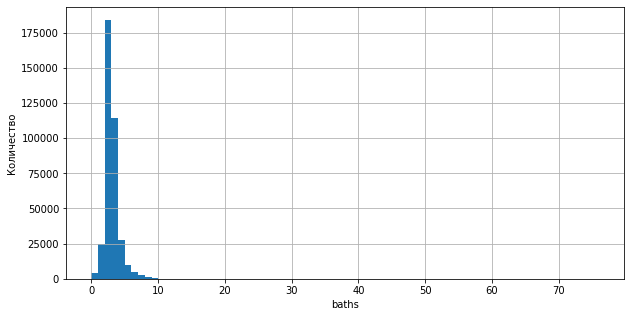

In [57]:
# построеним гистогамму распределения признака:
sign_hist(col, bn=76)

In [58]:
data.shape[0]

374578

# 6. fireplace

In [59]:
col = 'fireplace'
# выведем перечень уникальных значений признака:
uniq_val_count(col)

NaN                                                                           272036
yes                                                                            50352
Yes                                                                            20846
1                                                                              14204
2                                                                               2364
                                                                               ...  
Fireplace in Master Bedroom                                                        1
1 Fireplace, Fireplace-Living Rm, Stone Fireplace                                  1
Gas Logs, In Bedroom, In Great Room, In Kitchen/Dining Room, Wood Burning          1
Ceiling Fan, Extra Closets, Hot Tub, In-Law Quarters, Redecorated, Storage         1
Marble, Stove                                                                      1
Name: fireplace, Length: 1648, dtype: int64
Число найденных уника

In [60]:
# gредположим, что здесь пропуск означает отсутствие камина. Поэтому целесообразно заполнить все пропуски значением 'no':
data['fireplace'] = data['fireplace'].fillna('no')

In [61]:
# приведём всё к нижнему регистру:
data['fireplace'] = data['fireplace'].apply(lambda x: str(x).lower())
# data['fireplace'].value_counts()[:50]

In [62]:
# заменим значение '0' на 'no'
data['fireplace'] = data['fireplace'].apply(lambda x:'no' if x=='0' else x)

In [63]:
# проведем бинарное кодирование столбца: заменим все значения, которые не равны 'no' на 1:
data['fireplace'] = data['fireplace'].apply(lambda x: 1 if x!='no' else 0)

In [64]:
data.shape[0]

374578

# 10. zipcode

Проведем исследование и преобразование структуры данных признака zipcode до признака city с целью проверки корректности кода названию города.

In [65]:
# выведем перечень уникальных значений признака zipcode:
col = 'zipcode'
uniq_val_count(col)

32137         2141
33131         1556
34747         1484
78245         1390
34759         1332
              ... 
75147            1
07004-2214       1
34742            1
27529-2107       1
97034            1
Name: zipcode, Length: 4525, dtype: int64
Число найденных уникальных значений = 4525


In [66]:
# определим функцию получения 5-ти значного значения почтового индекса из признака zipcode:  
def get_zip(zdata_str):
    """Алгоритм получения 5-ти значного zip кода

    Args:
        zdata (object): исходный признак содержащий 5-ти значный zip код

    Returns:
        int64: 5-ти значный zip код объекта недвижимости
    """
    zdata = zdata_str.split('-')
    if len(zdata) > 1:
        return zdata[0]
    else: 
        return zdata_str

In [67]:
# выделим 5-ти значный zip код из значений с дополнительным идентификатором:
data[col] = data[col].apply(get_zip)

In [68]:
# снова выведем перечень уникальных значений признака zipcode:
uniq_val_count(col)

32137    2141
33131    1556
34747    1484
78245    1390
34759    1332
         ... 
41777       1
44443       1
75662       1
78112       1
97034       1
Name: zipcode, Length: 4314, dtype: int64
Число найденных уникальных значений = 4314


Видим, что в перечне уникальных значений присутствуют 4-х значные значения.  
Проведем проверку версии о том, что у данных значений опущена цифра 0 в первой позиции.  

In [69]:
# выведем несколько записей с 4-х значными значениями почтового индекса: 
data[data['zipcode'].str.len() == 4].head(3)

,status,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
68,Active,Manufactured,2.0,"{'atAGlanceFacts': [{'factValue': '1999', 'fac...",0,Lakewood,"[{'rating': ['4', '3', '2', 'NR', 'NR', 'NR', ...",2272,8701,2.0,NJ,1.0,NaN,No,21947773,"$269,000"
340,Active,Manufactured,1.0,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",0,Swanton,"[{'rating': ['4', '2', '3', '3', 'NR', 'NR'], ...",1834,5488,3.0,VT,2,NaN,No,4785291,"$209,900"
406,Active,Unknown,2.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,Charlotte,"[{'rating': ['9', '8', 'NR'], 'data': {'Distan...",NaN,5445,NaN,VT,NaN,NaN,No,4761154,"100,000"


Выборочная ппроверка соотвествия почтового индекса, полученного их 4-х значного значения и названия города в столбце city проведена с помощью ресурса https://zipcodes.org/us-zip-codes. Версия об отсутствии цифры 0 в первой позиции подтверждена.

In [70]:
# определим функцию добавления 0 к 4-ти значным значениям почтового индекса из признака zipcode:  
def add_zip(zdata_str):
    """Алгоритм добавления 0 к 4-ти значным значениям zip кода

    Args:
        zdata (object): исходный признак содержащий zip код

    Returns:
        int64: 5-ти значный zip код объекта недвижимости
    """
    if len(zdata_str) == 4:
        return '0' + zdata_str
    else: 
        return zdata_str

In [71]:
# приведем 4-х значные значения почтового индекса к 5-ти значному виду:
data[col] = data[col].apply(add_zip)

In [72]:
# выведем записи с длиной почтовых индексов не равной 5: 
data[(data['zipcode'].str.len() < 5) | (data['zipcode'].str.len() > 5)]

,status,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
30059,Active,Land,2.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,Vacaville,"[{'rating': ['7', '4', '6', '6', '10', '2'], '...",0,0,NaN,CA,NaN,NaN,No,21904829,"$380,000"
84991,Active,Detached,2.0,"{'atAGlanceFacts': [{'factValue': '1989', 'fac...",0,Other City Value - Out Of Area,"[{'rating': [], 'data': {'Distance': [], 'Grad...","4,000",123456,NaN,NY,NaN,NaN,No,A10764075,"899,999"
132967,Active,Apartment,2.0,"{'atAGlanceFacts': [{'factValue': '2001', 'fac...",0,Brooklyn,"[{'rating': ['9', '4', '7', 'NR'], 'data': {'D...","1,100",112229,NaN,NY,NaN,NaN,No,435007,"599,000"
160276,Active,High Rise,2.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,Coral Gables,"[{'rating': ['7', 'NR', '10', '5', '5'], 'data...","1,212",331446,NaN,FL,NaN,NaN,No,A10699951,"620,000"
303455,For sale,lot/land,3.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,Laredo,"[{'rating': ['4/10'], 'data': {'Distance': ['7...","243,849 sqft",0,NaN,TX,NaN,NaN,No,20193508,"$1,740,000"
82945,New,Other,3.0,"{'atAGlanceFacts': [{'factValue': '1995', 'fac...",0,Quito Ecuador,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,0,NaN,NY,NaN,NaN,No,3177007,"470,000"
229688,New,Unknown,3.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,Bonsall,"[{'rating': ['7/10', '7/10', '3/10'], 'data': ...",NaN,,449 acres,CA,NaN,OC19261036,No,NaN,"$60,000,000"
233581,Unknown,Townhouse,3.0,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",0,Fort Lauderdale,"[{'rating': ['3/10', '5/10', '7/10'], 'data': ...","2,043",,3,FL,NaN,NaN,No,"1744, Fort Lauderdale, FL","$425,000"


Для полученных записей, где в столбце city указан город, значение почтового индекса укажем с помощью ресурса https://zipcodes.org/us-zip-codes. Запись с местоположением недвижимости в городе Кито (Эквадор) удалим из датафрейм.

In [73]:
data = data[data['city'] != 'Quito Ecuador']

In [74]:
# удалим записи с длиной почтовых индексов не равной 5:
data = data[(data['zipcode'].str.len() == 5)]

In [75]:
uniq_val_count(col)

32137    2141
33131    1556
34747    1484
78245    1390
34759    1332
         ... 
12996       1
78408       1
20777       1
43054       1
97034       1
Name: zipcode, Length: 4259, dtype: int64
Число найденных уникальных значений = 4259


In [76]:
data.shape[0]

374570

# 7. city

In [77]:
# выведем упорядоченный по алфавиту перечень уникальных значений признака city:
col = 'city'
uniq_val_order(col)

                     25
--                    9
ALTAMONTE SPRINGS     2
ANN ARBOR             1
APOPKA                4
                     ..
Zapata                1
Zionsville            9
mcallen               1
the Hills             5
NaN                  34
Name: city, Length: 2022, dtype: int64
Число найденных уникальных значений = 2022


In [78]:
# переназначим пустые значения признака:
data[col] = data[col].replace({'':np.nan, '--':np.nan})

In [79]:
# переназначим значения признака по словарю с учетом сокращений, регистра символов, вариантов наименований и присвоения пустым ячейкам значения Unknown:
dict = {'Allentown City':'Allentown', 'Anderson Twp':'Anderson Township', 'Arrington':'Arlington', 'Ashville':'Asheville', 
        'Asheville City':'Asheville', 'Allentown City':'Allentown', 'Ave':'Aventura', 'Bainbridge Is':'Bainbridge Island', 
        'Baldwin Hills':'Baldwin', 'Bay Harbor Is':'Bay Harbor Islands', 'Bayside Hills':'Bayside', 'Bedford Hts':'Bedford Heights', 
        'Bee Caves':'Bee Cave','Bellerose Vlg':'Bellerose', 'Bellerose Manor':'Bellerose', 'Belllingham':'Bellingham', 
        'Biscayne':'Biscayne Park', 'Bonita Spgs':'Bonita Springs','Bonita springs':'Bonita Springs', 'Boston (Dorchester)':'Boston', 
        'Brookline':'Brooklyn', 'Cherry Valley':'New York', 'Coral gables':'Coral Gables', 'Commerce':'Commerce City', 
        'Cottonwood':'Cottonwood Heights', 'County Los Angeles':'Los Angeles','Cypress Hills':'Cypress', 'Dania beach':'Dania Beach', 
        'DENVER':'Denver', 'DALLAS':'Dallas', 'DACONO':'Dacono', 'CAPE HAZE':'Cape Haze', 'CELEBRATION':'Celebration', 
        'CENTENNIAL':'Centennial', 'CHARLOTTE':'Charlotte', 'CLEARWATER':'Clearwater', 'SBALDWIN':'Baldwin', 'BELLE ISLE':'Belle Isle', 
        'BEND':'Bend', 'BOCA GRANDE':'Boca Grande', 'BRANDON':'Brandon', 'BRIGHTON':'Brighton', 'BROOMFIELD':'Broomfield', 'BUFFALO':'Buffalo', 
        'ANN ARBOR':'Ann Arbor', 'APOPKA':'Apopka', 'ARCADIA':'Arcadia', 'AURORA':'Aurora', 'AVENTURA':'Aventura', 'DORAL':'Doral', 
        'Doctor Philips':'Doctor Phillips', 'DuPont':'Dupont', 'EDGEWATER':'Edgewater', 'EDGEWOOD':'Edgewood', 'ENGLEWOOD':'Englewood', 
        'Erie County':'Erie', 'Fairfield Twp.':'Fairfield Twp', 'Foreign Country':'Unknown', 'Fort wayne':'Fort Wayne', 
        'Fort worth':'Fort Worth', 'Garfield Hts':'Garfield Heights', 'Garrett Park':'Garrett', 'Grand prairie':'Grand Prairie', 
        'Hollywood Hills':'Hollywood', 'Hollywood Hills East':'Hollywood', 'Hollywood Pa':'Hollywood Park', 'Horizon':'Horizon City', 
        'JACKSONVILLE':'Jacksonville', 'Jc':'Unknown', 'KENNETH CITY':'Kenneth City', 'LAKE SUZY':'Lake Suzy', 'LAKEWOOD':'Lakewood', 
        'Lakewood Twp.':'Lakewood', 'Lauderdale By the Sea':'Lauderdale By The Sea', 'Lehigh acres':'Lehigh Acres', 'Leona valley':'Leon Valley', 
        'MADEIRA BEACH':'Madeira Beach', 'Madeira':'Madeira Beach', 'Mayfield Hts':'Mayfield Heights', 'Mc Allen':'McAllen', 
        'Mc Gregor':'McGregor', 'Mc Kinney':'McKinney', 'Mem':'Memphis', 'N Miami Beach':'Miami Beach', 'NASHVILLE':'Nashville', 
        'NORTH FORT MYERS':'North Fort Myers', 'NORTH PORT':'North Port', 'North Pt':'North Port', 
        'NORTH REDINGTON BEACH':'North Redington Beach', 'NORTHGLENN':'Northglenn', 'Other':'Unknown', 
        'Other City Not In the State of Florida':'Other City - In The State Of Florida', 'Other City Value - Out Of Area':'Unknown', 
        'Other City Value Out Of Area':'Unknown', 'Outside Area (Outside Ca)':'Unknown', 'P C Beach':'Panama City Beach', 
        'SPT CHARLOTTE':'Port Charlotte', 'PINELLAS PARK':'Pinellas Park', 'PLACIDA':'Placida', 'POINCIANA':'Poinciana', 
        'PORT CHARLOTTE':'Port Charlotte', 'PROVO':'Provo', 'Provo Canyon':'Provo', 'PUNTA GORDA':'Punta Gorda', 
        'REDINGTON BEACH':'Redington Beach', 'REDINGTON SHORES':'Redington Shores', 'REUNION':'Reunion', 'RIVERVIEW':'Riverview', 
        'Royal palm beach':'Royal Palm Beach', 'S.a.':'Unknown', 'Sa':'Unknown','SAINT JOHNS':'Saint Johns', 
        'SAINT PETE BEACH':'Saint Pete Beach', 'Saint pete beach':'Saint Pete Beach', 
        'SAINT PETERSBURG':'Saint Petersburg', 'SEATTLE':'Seattle','SOUTH PASADENA':'South Pasadena', 'South pasadena':'South Pasadena', 
        'SPRING HILLe':'Spring Hill', 'Spring hill':'Spring Hill', 'SPRINGFIELD':'Springfield', 'ST PETE':'St Pete', 
        'ST PETE BEACH':'St Pete Beach', 'ST PETERSBURG':'St Petersburg', 'SUNRISE':'Sunrise', 'Silver Lakes':'Silver Lake', 
        'Slc':'Unknown', 'Soddy-Daisy':'Soddy Daisy', 'St. Petersburg ':'Saint Petersburg ', 'St. Petersburg ':'Saint Petersburg',
        'St. George':'St George', 'St. Johns':'St George', 'St. Johns':'St Johns', 'TACOMA':'Tacoma', 'TAMPA':'Tampa', 
        'THORNTON':'Thornton', 'TIERRA VERDE':'Tierra Verde', 'TREASURE ISLAND':'Treasure Island', "Town 'N' Country":'Town North Country', 
        'Uninc':'Unincorporated', 'WESTMINSTER':'Westminster', 'WINTER PARK':'Winter Park', 'NaN':'Unknown', np.NAN:'Unknown', 
        'mcallen':'McAllen', 'North port':'North Port', 'Nyc':'New York', 'New York City':'New York', 'New york':'New York', 
        'Fairfield Twp.':'Fairfield Twp', 'E. New York':'New York', '--':'Unknown', ' ':'Unknown', 'City Center':'Unknown', 
        'College Pt':'College Point', 'Herkimer Ny':'Herkimer', 'OCOEE':'Ocoee', 'ODESSA':'Odessa', 'Opa-Locka':'Opa Locka', 
        'Port St Lucie':'Port Saint Lucie', 'Piney Pt Village':'Piney Point Village', 'Pt Saint Lucie':'Port Saint Lucie', 
        'Pt Isabel':'Port Isabel', 'Pt Charlotte':'Port Charlotte', 'Pt Arthur':'Port Arthur', 'Richmond Hts':'Richmond Heights', 
        'South lyon':'South Lyon', 'St. Petersburg':'St Petersburg', 'TEMPLE TERRACE':'Temple Terrace', 'Unincorporated':'Unknown'}
remap_val(dict, col)

In [80]:
# в перечне уникальных значений присутствуют одинаковые значения, отличающиеся только регистром символов
# приведем все значения к нижнему регистру:
data[col] = data[col].str.lower()

In [81]:
uniq_val_order(col)

abilene       134
abingdon      116
accokeek        3
adams           5
addison        25
             ... 
youngtown       8
yuba city      45
zanesville      4
zapata          1
zionsville      9
Name: city, Length: 1829, dtype: int64
Число найденных уникальных значений = 1829


In [82]:
data.shape[0]

374570

# 9. sqft

In [83]:
col = 'sqft'
# выведем перечень уникальных значений признака sqft:
uniq_val_count(col)


NaN                                        40261
0                                          11853
1,200 sqft                                   839
1,000 sqft                                   654
1,100 sqft                                   573
                                           ...  
Total interior livable area: 8,563 sqft        1
89,340 sqft                                    1
484,900 sqft                                   1
6,890 sqft                                     1
6,193                                          1
Name: sqft, Length: 25353, dtype: int64
Число найденных уникальных значений = 25353


In [84]:
# выделим числа из строковых значений признака sqft:
pattern = re.compile('\d+[,]?\d+')
find_pattern(pattern, col)

In [85]:
# удалим разделяющую запятую числовых значений в признаке sqft:
data[col] = data[col].astype('str').apply(repl_symb, w1=',', w2='')

In [86]:
uniq_val_count(col)

nan      53022
1200      1417
1000      1022
1500      1008
1800       976
         ...  
8429         1
15600        1
10162        1
17583        1
6193         1
Name: sqft, Length: 9863, dtype: int64
Число найденных уникальных значений = 9863


In [87]:
data.shape[0]

374570

In [88]:
# заполним пропуски медианным значением в разрезе уникальных значений контрольного признака:
data = fill_gaps(col, crit='propertyType', dec=0)

24
1634.5
2596.0
1100.0
1306.0
1168.0
2035.0
1100.0
2150.0
996.0
1200.0
1428.0
2034.0
1288.0
2324.0
2022.0
1789.5
2059.0
1750.0
1402.0
1647.0
2162.0
2776.0
1705.0
1710.0
New Shape:  (374570, 16)


In [89]:
# Переводим в числовой формат:
data[col] = data[col].apply(lambda x: int(x))

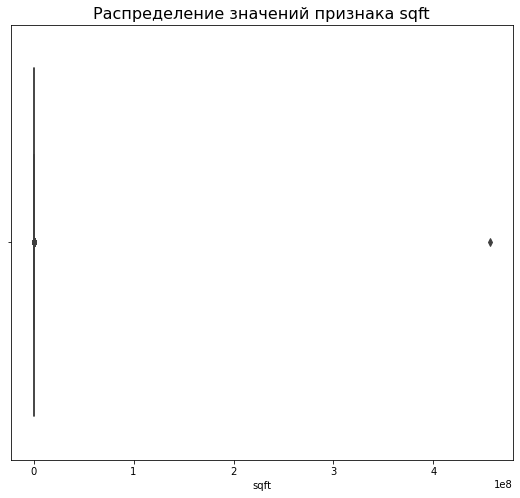

In [90]:
# построим коробчатую диаграмму распределения значений признака:
box_plot(col)

In [91]:
# удалим выбросы уникальных значений признака:
data = outliers_iqr_mod(data, col)

New Shape:  (349806, 16)


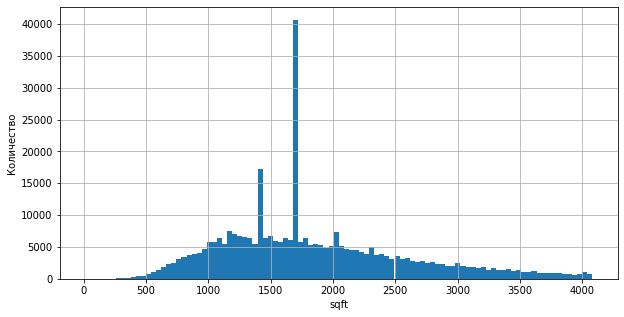

In [92]:
# построим гистограмму распределения значений признака:
sign_hist(col, bn=100)

Пики вызваны заполгнением пустых значений

In [93]:
data.shape[0]

349806

# 11. beds

In [94]:
col = 'beds'
# выведем перечень уникальных значений признака beds:
uniq_val_count(col)

NaN            85429
3 Beds         52851
4 Beds         32616
3              31094
2 Beds         25954
               ...  
2.57 acres         1
3.4 acres          1
18.64 acres        1
9,025 sqft         1
6,299 sqft         1
Name: beds, Length: 1133, dtype: int64
Число найденных уникальных значений = 1133


Видим, что в части записей значения признака beds указаны в акрах и кв.футах. Эти данные непосредственной информации о количестве спальных комнат не несут, установим для данных записей значение Unknown для признака beds.

In [95]:
# определим функцию замены значения признака col при наличии ключевых слов:
def remove_data(data_str, key_list):
    """Алгоритм замены значения признака при наличии ключевых слов

    Args:
        data_str (object): исходный признак
        key_list (list): список ключевых слов
         
    Returns:
        object: исходное значение признака при наличии ключевых слов или 'Unknown' при их отсутствии
    """
    s=0
    for item in key_list: 
        if item in data_str:  # проверка наличия элементов списка ключевых слов в аргументе функции 
            s+=1 
    if s==1:
        return 'Unknown'   
    else: return data_str   

In [96]:
# переназначим значения, содержащие данные в акрах и кв.футах:
key_words = ['acres', 'sqft']
data[col] = data[col].astype('str').apply(remove_data, key_list=key_words)

In [97]:
uniq_val_count(col)

nan                                                                                 85429
3 Beds                                                                              52851
4 Beds                                                                              32616
3                                                                                   31094
2 Beds                                                                              25954
                                                                                    ...  
1 Bath, 2 Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room        1
15.0                                                                                    1
32 Beds                                                                                 1
14 bd                                                                                   1
16.0                                                                                    1
Name: beds

In [98]:
# переназначим значения признака по словарю с учетом вариантов наименований и присвоения пустым ячейкам значения Unknown:
dict = {'':'Unknown', 
        '1 Bath, 3 or More Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator':'3', 
        '2 Baths, 3 or More Bedrooms':'3', 
        "Based on Redfin's Raleigh data, we estimate the home's value is $708,248, which is 1.2% more than its current list price.":'Unknown', 
        '1 Bath, 2 Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room':'2', 
        '3 or More Bedrooms, Dining Room, Living Room, Range/Oven, Refrigerator':'3', 
        '1 Bath, 2 Bedrooms, Living Room, Range/Oven, Refrigerator':'2', 
        '1 Bath, 2 Bedrooms':'2', 
        "Based on Redfin's St Johns data, we estimate the home's value is $360,731, which is 2.2% less than its current list price.":'Unknown', 
        '1 Bath, 2 Bedrooms, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator':'2', 
        '# Bedrooms 1st Floor':'Unknown'}
remap_val(dict, col)

In [99]:
# выделим числа из строковых значений признака beds:
# data[col] = data[col].astype('str').apply(find_num)
pattern = re.compile('\d+')
find_pattern(pattern, col)

In [100]:
uniq_val_count(col)

3      104685
NaN    103922
4       63478
2       49651
5       14717
1        6111
6        3669
0        1327
7         905
8         735
9         271
10        108
12         67
11         49
64         44
16         20
13          7
18          6
15          5
20          4
23          4
14          4
34          3
24          3
32          2
17          1
42          1
44          1
40          1
46          1
28          1
26          1
47          1
29          1
Name: beds, dtype: int64
Число найденных уникальных значений = 34


In [101]:
# заполнение пропусков медианными значениями с учетом площади sqft:
spec_sqft1 = (data[data['beds'].isnull() == False]['beds'].astype('int').sum())
spec_sqft2 = (data[data['beds'].isnull() == False]['sqft'].astype('int').sum())
spec_sqft = int(spec_sqft1)/int(spec_sqft2)
print(spec_sqft)
for i in range(data.shape[0]):
    if pd.isnull(data.iloc[i, data.columns.get_loc(col)]) == True:
        data.iat[i, data.columns.get_loc(col)] = round(int(data.iloc[i, data.columns.get_loc('sqft')])*spec_sqft , 0)

0.0016762479556376411


In [102]:
uniq_val_count(col)

3      104685
4       63478
2       49651
3.0     48642
2.0     26816
5       14717
1.0     10703
4.0      9181
1        6111
5.0      5012
6        3669
6.0      2844
0        1327
7         905
8         735
7.0       655
9         271
10        108
0.0        69
12         67
11         49
64         44
16         20
13          7
18          6
15          5
23          4
14          4
20          4
34          3
24          3
32          2
17          1
42          1
44          1
26          1
46          1
28          1
29          1
40          1
47          1
Name: beds, dtype: int64
Число найденных уникальных значений = 41


In [103]:
# Переводим в числовой формат
data[col] = data[col].apply(lambda x: int(x))

In [104]:
uniq_val_count(col)

3     153327
2      76467
4      72659
5      19729
1      16814
6       6513
7       1560
0       1396
8        735
9        271
10       108
12        67
11        49
64        44
16        20
13         7
18         6
15         5
20         4
23         4
14         4
34         3
24         3
32         2
17         1
42         1
44         1
40         1
46         1
28         1
26         1
47         1
29         1
Name: beds, dtype: int64
Число найденных уникальных значений = 33


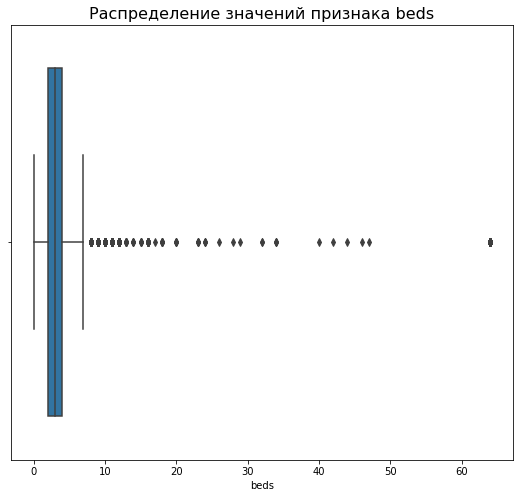

In [105]:
# построим коробчатую диаграмму распределения значений признака:
box_plot(col)

In [106]:
# выведем максимальную площадь домовлаадений с количеством спален более 40:
data[data[col]>40]['sqft'].max()

3840

Наибольшая площадь домовладений с количеством спален более 40 составляет 3840 кв.футов (менее 100 кв.футов общей площади на 1 спальню), что явно указывает на то, что количество спален более 40 является явным выбросом.

In [107]:
# исключим из рассмотрения записи с количеством спаден более 40:
data = data[data[col]<40]

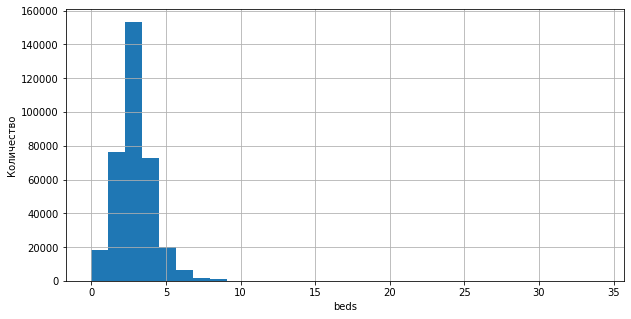

In [108]:
# построим гистограмму распределения значений признака:
sign_hist(col, bn=30)

# 12. state

In [109]:
col = 'state'
# выведем перечень уникальных значений признака:
uniq_val_count(col)

FL    108959
TX     77149
NY     22089
CA     21278
NC     19776
TN     16943
WA     12779
OH     11964
IL      8465
NV      7847
GA      6079
CO      5784
PA      5263
MI      5009
DC      4260
AZ      3251
IN      3017
OR      2560
MA      1415
UT      1171
MD       987
MO       782
VT       782
VA       719
WI       404
NJ       358
IA       236
ME       220
KY        81
OK        47
MS        39
SC        28
MT         7
DE         5
AL         1
Fl         1
OT         1
OS         1
Name: state, dtype: int64
Число найденных уникальных значений = 38


In [110]:
# исключим различное написание штата Флорида:
data[col] = data[col].replace('Fl', 'FL')

# 13. stories

In [111]:
# выведем перечень уникальных значений признака homeFacts:
col = 'stories'

In [112]:
# определим количество пропусков:
data[col].isna().sum()

140936

Признак stories имеет 40% пропусков. Удалим его.

In [113]:
# удалим признак stories:
data = data.drop(['stories'], axis=1)

# 5. homeFacts

In [114]:
col = 'homeFacts'

In [115]:
data.reset_index(drop= True , inplace= True )

In [116]:
# преобразуем строку в словарь
dictionary = ast.literal_eval(data[col][17])
print(dictionary)

{'atAGlanceFacts': [{'factValue': '1925', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': 'Natural Gas Heat', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '7,000 Sq. Ft.', 'factLabel': 'lotsize'}, {'factValue': '$105 / Sq. Ft.', 'factLabel': 'Price/sqft'}]}


In [117]:
# рассмотрим значения словаря:
print(dictionary.values())

dict_values([[{'factValue': '1925', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': 'Natural Gas Heat', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '7,000 Sq. Ft.', 'factLabel': 'lotsize'}, {'factValue': '$105 / Sq. Ft.', 'factLabel': 'Price/sqft'}]])


In [118]:
# получим список значний словаря:
my_list = list(dictionary.values())
my_list[0][0]

{'factValue': '1925', 'factLabel': 'Year built'}

In [119]:
# функция получения списка значений ключей factLabel признаков из списка словарей признака homeFacts:
my_list[0]
col_lst = []
for i in range (0, len(my_list[0])):
    col_lst.append(my_list[0][i]['factLabel'])
col_lst

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [120]:
# получим список значний словаря:
my_list = [elem[0] for elem in dictionary.values()]
my_list

[{'factValue': '1925', 'factLabel': 'Year built'}]

In [121]:
# функция получения имен признаков из списка словарей:
def dict_key(col):
    dict_lst1 = ast.literal_eval(data[col][0])
    dict_lst2 = list(dict_lst1.values())
    col_lst = []
    for i in range (0, len(dict_lst2[0])):
        col_lst.append(dict_lst2[0][i]['factLabel'])
    return  col_lst

In [122]:
# функция получения данных из списка словарей
def dict_val(data2, key):
    dict_lst1 = ast.literal_eval(data2)
    dict_lst2 = list(dict_lst1.values())
    for j in range (0, len(dict_lst2[0])):
        if dict_lst2[0][j]['factLabel'] == key:
            return dict_lst2[0][j]['factValue'] 

In [123]:
# получим имена признаков:
dict_key('homeFacts')

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [124]:
# создадим новые признаки из списка занчений признака homeFacts:
col_lst = dict_key(col)
for j in col_lst:
    data[j] = data[col].apply(dict_val, key=j)

In [125]:
# Удалим исходный признак homeFacts:
data = data.drop([col], axis=1)

Проведем анализ и обработку вновь полученных признаков.

# 5.1. Year built

In [126]:
col = 'Year built'
# выведем перечень уникальных значений признака Year built:
uniq_val_count(col)

        57293
2019    29838
2006     7184
2005     6776
2007     6291
        ...  
1750        1
1855        1
1788        1
1804        1
1           1
Name: Year built, Length: 227, dtype: int64
Число найденных уникальных значений = 227


Проведем обработку признака Year built (перевод в числовой формат с заполнением пропусков и выбросов на постоянное значение)

In [127]:
# Заполним значения с пометкой NA постоянным значением np.nan:
data[col] = data[col].fillna(np.nan)
# выбросы в данных заменим на np.nan
data[col] = data[col].replace({'559990649990':np.nan, '':np.nan, 'No Data':np.nan, '1':np.nan})

In [128]:
# замена отсутствующих значений на среднее с учетом статуса объекта недвижимости:
# Переводим в числовой формат
data = fill_gaps(col)

16
1987.0
1964.0
1990.0
1987.0
1973.0
1999.0
1983.0
1981.0
1958.0
2019.0
1974.5
1991.0
1975.0
1993.0
1988.0
1972.0
New Shape:  (349757, 21)


In [129]:
# Переводим в числовой формат
data[col] = data[col].apply(lambda x: int(x))

In [130]:
# выведем перечень уникальных значений признака:
uniq_val_count(col)

1981    31931
2019    30584
1987    29312
2006     7184
1988     6794
        ...  
1845        1
1828        1
1823        1
1859        1
1735        1
Name: Year built, Length: 222, dtype: int64
Число найденных уникальных значений = 222


In [131]:
# удалим явные выбросы с датами потройки ранее 1800 г.
data = data[data[col]>=1800]

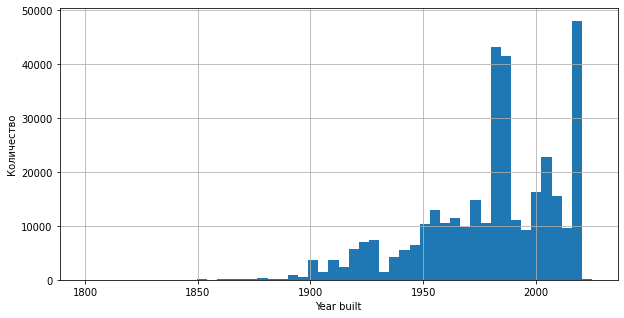

In [132]:
# построим гистограмму распределения значений признака:
sign_hist(col, bn=50)

In [133]:
data.shape[0]

349736

# 5.2. Remodeled year

In [134]:
col = 'Remodeled year'
# выведем перечень уникальных значений признака Remodeled year:
uniq_val_count(col)

        186779
None     24927
2006      4970
2005      4262
2007      3826
         ...  
1888         1
1862         1
1111         1
1846         1
1800         1
Name: Remodeled year, Length: 153, dtype: int64
Число найденных уникальных значений = 153


In [135]:
# определим долю пропущенных значений признака Remodeled year:
lst_ry = ['', ' ', None, '0']
display((data[col].isin(lst_ry).sum())/data[col].shape[0])

0.6059885170528627

Полученный признак имеет более 60% пропущенных значений.   
Предположим, что в случае отсутствия данных реконструкция не проводилась.

In [136]:
# Переназначим пропущенные значения:
data[col] = data[col].apply(lambda x: 0 if x in lst_ry else x)

In [137]:
# Переводим в числовой формат
data[col] = data[col].apply(lambda x: int(x))

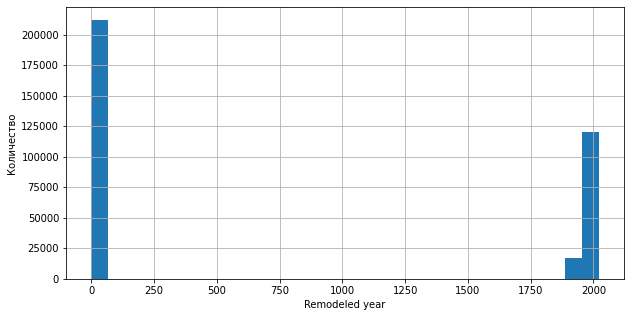

In [138]:
# построеним гистогамму распределения признака:
sign_hist(col, 30)

In [139]:
# Переназначим значения для превода признака в бинарный (1-реконструкция проводилась, 0-не проводилась):
data[col] = data[col].apply(lambda x: 1 if x!=0 else 0)

In [140]:
data.shape[0]

349736

# 5.3. Heating

In [141]:
col = 'Heating'
# выведем перечень уникальных значений признака Heating:
uniq_val_count(col)

                                                             99270
Forced Air                                                   76768
Forced air                                                   47619
Other                                                        26834
Electric                                                      9771
                                                             ...  
, Electric Hot Air, g-Energy Star HVAC                           1
Hot Water, In Floor, Radiant Floor                               1
Water Heater,Water Heater- Electric,Water Heater- Propane        1
Forced Air, Hot Water, Radiant, Stove - Wood                     1
Baseboard Electric                                               1
Name: Heating, Length: 1760, dtype: int64
Число найденных уникальных значений = 1760


Видим что в признаке Heating присутствуют различеные вариации данных как  о теплоносителе (воздух, вода) так и об источнике тепла (газ, электричество, тепловой насос, дрова). Выделим основные группы (с учетом имеющегося сочетания нескольких систем в одном объекте недвижимости).

In [142]:
# переименуем равноценные значения признака Heating:
data[col] = data[col].replace({r'(\ Propane)':' Gas', r'(\ PROPANE)':'Gas'}, regex=True)

In [143]:
# функция получения данных о типе системы отопления из признака Heating:
def heat_type(sign, key_lst):
    heat_lst = []   
    if ((sign == 'None') or (sign == 'No Cooling')):
        return 'None'
    elif ((sign == '') or (sign == ' ')):
        return 'Unknown'
    else:
        for item in key_lst:
            if item in sign.lower():
                heat_lst.append(item)
        if len(heat_lst) != 0:
            return (' '.join(map(str, heat_lst)))
        else: 
            return 'Other'

In [144]:
# сгруппируем значения, содержащие ключевые слова:
key_words = ['gas', 'electric', 'pump', 'oil', 'wood', 'air', 'wather', 'central']
data[col] = data[col].astype('str').apply(heat_type, key_lst=key_words)

In [145]:
uniq_val_count(col)

air                              126627
Unknown                           99270
Other                             48479
electric                          13149
electric central                  11876
                                  ...  
gas electric pump wood air            1
pump oil central                      1
electric pump oil                     1
gas electric wood air                 1
gas electric wood air central         1
Name: Heating, Length: 67, dtype: int64
Число найденных уникальных значений = 67


In [146]:
# удалим выбросы в разрезе уникальных значений контрольного признака:
data = top_values_del(col)

New Shape:  (349736, 21)


# 5.4. Cooling

In [147]:
col = 'Cooling'
# выведем перечень уникальных значений признака Cooling:
uniq_val_count(col)

Central                                               145202
                                                      114032
Central Air                                            13527
No Data                                                10100
Has Cooling                                             8734
                                                       ...  
, Gas Hot Air/Furnace, Heat Pump - AC, Natural Gas         1
Central Air, Wall/Window Unit(s), Electric, Gas            1
Central Air/Evap                                           1
Electric Fuel                                              1
Central Air, Gas (Hot Air), Propane                        1
Name: Cooling, Length: 1262, dtype: int64
Число найденных уникальных значений = 1262


Видим что в признаке Cooling присутствуют различеные вариации данных об охладителе (воздушный кондиционер, испарительный охладитель, тепловой насос, оконные системы), а также типе системы (локальная, централизованная). Выделим основные группы (с учетом имеющегося сочетания нескольких систем в одном объекте недвижимости).

In [148]:
# переименуем равноценные значения признака Cooling:
data[col] = data[col].replace({'Wall':'a/c', 'Air Conditioning':'a/c', 
                               'Fan(s)':'Fans', 'Fan':'Fans'})

In [149]:
# функция получения данных о типе системы охлаждения из признака Cooling:
def cool_type(sign, key_lst):
    heat_lst = []   
    if ((sign == 'No') or (sign == 'No Cooling')):
        return 'None'
    elif ((sign == '') or (sign == ' ')):
        return 'Unknown'
    else:
        for item in key_lst:
            if item in sign.lower():
                heat_lst.append(item)
        if len(heat_lst) != 0:
            return (' '.join(map(str, heat_lst)))
        else: 
            return 'Other'

In [150]:
# сгруппируем значения, содержащие ключевые слова:
key_words = ['central', 'a/c', 'fans', 'pump', 'evaporative', 'refrigeration', 'window']
data[col] = data[col].astype('str').apply(cool_type, key_lst=key_words)

In [151]:
uniq_val_count(col)

central                              178519
Unknown                              114032
Other                                 38937
central a/c                            6414
a/c                                    4128
refrigeration                          2501
evaporative                            1168
central pump                            935
pump                                    900
window                                  884
central a/c pump                        319
a/c pump                                269
central window                          214
central fans                            197
central refrigeration                   124
central evaporative                      84
central a/c window                       47
evaporative refrigeration                12
a/c window                               12
refrigeration window                      8
central fans window                       8
central fans pump                         5
fans                            

In [152]:
# определим долю пропущенных значений признака:
lst = ['Unknown']
display((data[col].isin(lst).sum())/data[col].shape[0])

0.32605165038772105

In [153]:
# выделим 10 самых популярных значений признака (без удаления записей):
data = top_values(col)

New Shape:  (349736, 21)


# 5.5. Parking

In [154]:
col = 'Parking'
# выведем перечень уникальных значений признака Parking:
uniq_val_count(col)

                                                                                         161099
Attached Garage                                                                           63572
2 spaces                                                                                  26628
1 space                                                                                   13964
No Data                                                                                   12734
                                                                                          ...  
Driveway, Parking Space - 1, Parking Space - 2, Parking Space - 3, Parking Space - 4+         1
Carport, Paved                                                                                1
Electric Door Opener, Separate Strge Area, RV Parking, RV Garage, Carport Spaces              1
Electric Door Opener, Golf Cart Garage, Dir Entry frm Garage                                  1
171 spaces                              

Видим что в признаке Parking присутствуют различеные вариации данных о типе гаража (отдельно стоящий или пристроенный гараж, навес, крытые парковочные места, парковка ), а также типе системы (локальная, централизованная). Выделим основные группы (с учетом имеющегося сочетания нескольких типов).

In [155]:
# переименуем равноценные значения признака Parking:
data[col] = data[col].replace({r"(\ Attch'd)":' Attached'}, regex=True)                            

In [156]:
# функция получения данных о типе системы охлаждения из признака Parking:
def cool_type(sign, key_lst):
    cool_lst = []   
    if (sign == '0'):
        return 'None'
    elif ((sign == '') or (sign == ' ') or (sign == 'No Data')):
        return 'Unknown'
    else:
        for item in key_lst:
            if (re.search(item, sign.lower()) != None):
                cool_lst.append(re.search(item, sign.lower())[0])
        if len(cool_lst) != 0:
            return (' '.join(map(str, cool_lst)))
        else: 
            return 'Other'

In [157]:
# сгруппируем значения, содержащие ключевые слова:
key_words = ['attached', 'detached', 'garage', 'carport', 'slab', 'parking', 'off street', 'on street', 'assigned', 
             r'(\d+)', r'(\bspaces )', r'(\bcar )']
data[col] = data[col].astype('str').apply(cool_type, key_lst=key_words)

In [158]:
uniq_val_count(col)

Unknown                                       173833
attached garage                                64046
2                                              29373
1                                              16880
detached garage                                12554
                                               ...  
attached garage parking on street assigned         1
parking assigned 3                                 1
parking assigned 17                                1
parking on street 1 car                            1
171                                                1
Name: Parking, Length: 380, dtype: int64
Число найденных уникальных значений = 380


In [159]:
# дополнительно переименуем равноценные значения признака Parking после группировки значений:
dict = {'off street': 'off street parking', 
        'assigned 2':'assigned 2 spaces', 
        'attached':'attached garage',
        'parking':'parking',
        'detached':'detached garage'}
for i in range (len(dict)):
    data[col] = data[col].astype('str').apply(lambda x: list(dict.values())[i] if x.__contains__(list(dict.keys())[i]) else x)
    
data[col] = data[col].apply(lambda x: x +' spaces' if (re.fullmatch(r'(\d+)', x) != None) else x)
data[col] = data[col].replace({r'(\ car )':' spaces'}, regex=True)       

In [160]:
uniq_val_count(col)

Unknown             173833
attached garage      72870
2 spaces             29373
1 spaces             16880
detached garage      13520
                     ...  
garage carport 4         1
210 spaces               1
89 spaces                1
99 spaces                1
171 spaces               1
Name: Parking, Length: 119, dtype: int64
Число найденных уникальных значений = 119


In [161]:
# выделеним самые популярные значения признака:
data = top_values_del(col)

New Shape:  (349736, 21)


# 5.6. lotsize

In [162]:
col = 'lotsize'
# выведем перечень уникальных значений признака lotsize:
uniq_val_count(col)

                 32058
None             27600
—                23656
No Data           5198
-- sqft lot       3727
                 ...  
7,713 Sq. Ft.        1
8,462 Sq. Ft.        1
9,224 Sq. Ft.        1
2,746 Sq. Ft.        1
1,574 sqft           1
Name: lotsize, Length: 35910, dtype: int64
Число найденных уникальных значений = 35910


Видим, что данные о площади участка представлены в двух единицах измерения (акрах, кв.футах), а также без указания единицы измерения.
Приведем данные к одной единице измерения.

In [163]:
# дополнительно переименуем равноценные значения признака lotsize после группировки значений:
data[col] = data[col].replace({r'(\ Sq. Ft.)':' sqft', r'(\ Acres)':' acres', r'(\ sqft lot)':' sqft', r'(\ acres lot)':' acres', 
                               r'(\ acre lot)':' acres'}, regex=True)

In [164]:
# переназначим пустые и равноценные значения признака lotsize:
data[col] = data[col].replace({'-- sqft':'Unknown', '--':'Unknown'})

In [165]:
# функция преобразования площади в кв.футы:
def conv_sqft(plot):
    """Алгоритм преобразования площади в кв.футы из исходного признака
    
    Args:
        plot (object): исходный признак содержащий данные о площади
        
    Returns:
        object: площадь участка в кв.футах 
    """ 
    plot_list = plot.split(' ')
    if plot in ['-- sqft', '', ' ', 'No Data', '—', 'Unknown']:
        return np.nan
    if plot == 'None':
        return 0
    if len(plot_list) == 2:
        if plot_list[1].lower() == 'acres':
            plot_1 = re.sub(',', '', plot_list[0])
            plot_sqft = round(float(plot_1)*43560, 0)
            return int(plot_sqft) 
        elif plot_list[1].lower() == 'sqft':
            plot_sqft = re.sub(',', '', plot_list[0])
            return int(plot_sqft) 
    elif (len(plot_list) == 1) and (float(re.sub(',', '', plot))<=1) and (float(re.sub(',', '', plot))>0):
        plot_sqft = round(float(re.sub(',', '', plot))*43560, 0)
        return int(plot_sqft) 
    else:   
        return int(re.sub(',', '', plot))
    
data[col] = data[col].astype('str').apply(conv_sqft)    

In [166]:
# заполним пропуски медианным значением в разрезе уникальных значений контрольного признака:
data = fill_gaps(col, crit='propertyType')

24
7575.0
7200.0
0.0
6081.0
0.0
6363.0
20473.0
7566.0
1933.5
1.0
17860.0
7710.0
5998.0
3484.0
6309.0
10413.5
7549.0
8546.0
0.0
1829.0
7670.0
9583.0
7405.0
16117.0
New Shape:  (349736, 21)


In [167]:
# Переводим в числовой формат
data[col] = data[col].apply(lambda x: int(x))

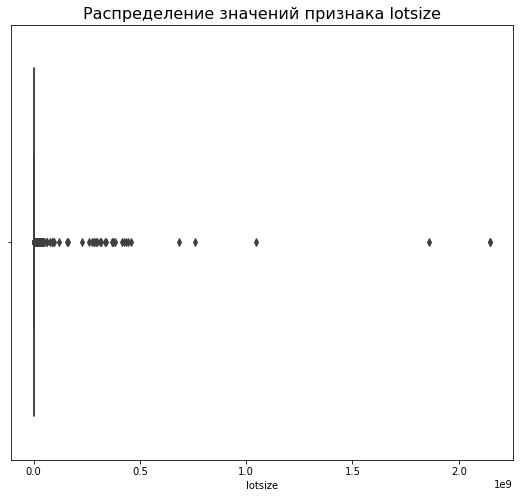

In [168]:
# построим коробчатую диаграмму распределения значений признака:
box_plot(col)

In [169]:
# удалим выбросы в значениях признака в разрезе уникальных значений контрольного признака:
data = m_del(col, crit='status')

16
New Shape:  (349424, 21)


In [170]:
# удалим выбросы в значениях признака в разрезе уникальных значений контрольного признака:
data = m_del(col, crit='propertyType')

24
New Shape:  (344709, 21)


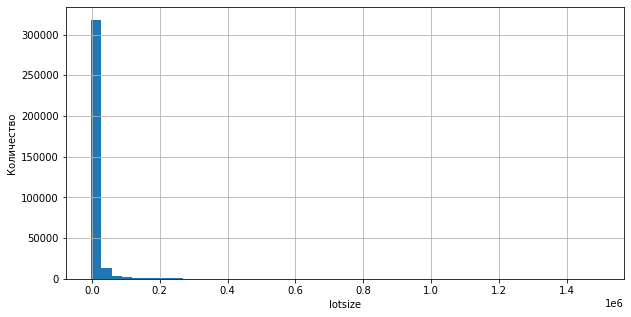

In [171]:
# построеним гистогамму распределения признака:
sign_hist(col, 50)

# 5.7 Price/sqft

Данные столбца Price/sqft несут непосредственную информацию об удельной стоимости домовладения дибо придомового участка в рассчете на кв.фут. При этом выборочная проверка соответствия значения стоимости домовладения полученная перемножением данных столбцов Price/sqft и Sqft данным целевого признака target показывает, что соответствие отсутствует. Возможно данные признака Price/sqft являются утечкой. Проверим это в дальнейшем при определнии корреляции признаков с целевым. 

In [172]:
col = 'Price/sqft'
# выведем перечень уникальных значений признака Price/sqft:
uniq_val_count(col)

None               55940
                    4969
No Data             1202
No Info              849
$1/sqft              773
                   ...  
$1,275                 1
$1,494                 1
$1,622                 1
$1,943                 1
$1,499,000/sqft        1
Name: Price/sqft, Length: 5759, dtype: int64
Число найденных уникальных значений = 5759


In [173]:
# Выделяем цифровые значения
pattern = re.compile('\d+[.]?[,]?\d+')
find_pattern (pattern, col)

# Убираем запятые
data[col] = data[col].astype('str').apply(lambda x: x.replace(',', ''))

In [174]:
# заполним пропуски медианным значением в разрезе уникальных значений контрольного признака:
data = fill_gaps(col, crit='status')

16
169.0
68.0
114.0
183.0
108.0
161.0
174.0
176.0
121.0
189.0
138.0
154.0
174.0
128.0
188.0
154.0
New Shape:  (344709, 21)


In [175]:
# Переводим в числовой формат
data[col] = data[col].apply(lambda x: int(x))

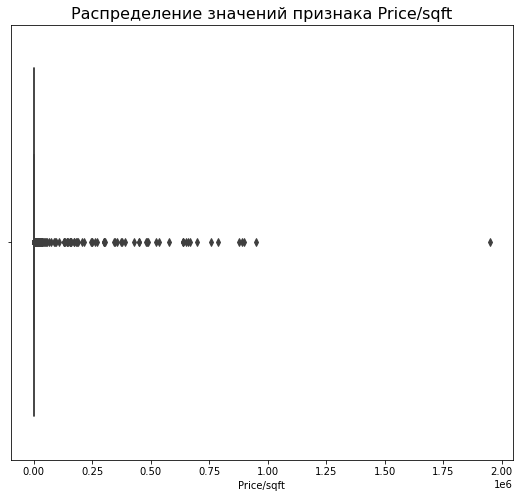

In [176]:
# построим коробчатую диаграмму распределения значений признака:
box_plot(col)

Видим явные выбросы значений признака Price/sqft со значением более 1000 долларов за кв.фут  
https://www.visualcapitalist.com/interactive-map-price-per-square-foot-us-housing-markets/  

In [177]:
# определим количество записей с аномальными значениями признака:
data[data['Price/sqft'] > 1000].shape[0]

5776

In [178]:
data = data[data['Price/sqft'] <= 1000]

Удаление выбросов отложим до этапа опредедения значимости признаков. В случае если признак окажется утечкой,  то удаление выбросов в нем на данном этапе приведет к необоснованному уменьшению количества записей.

In [179]:
data.shape[0]

338933

# 4.  schools

Значение признака 'schools' представляет из себя список состоящий из словаря, содержащего данные о учебных заведениях (наименование, расстояние, рейтинг, оценка). Создадим из этих данных отдельные признаки.

Отметим, что списки значений с данным об учебных заведениях имеют различную длину в разных записях. 

In [180]:
col = 'schools'

In [181]:
# переназначим индексы записей датафрейм:
data = data.reset_index(drop=True)

In [182]:
# установим диапазоны длин списков данных о расстоянии до учебных заведений:
lst_dist=[]
for i in range (0, data.shape[0]):
    lst_dist.append(len((ast.literal_eval(data['schools'][i]))[0]['data']['Distance']))
print('макс.длина = ', max(lst_dist))
print('мин.длина = ', min(lst_dist))
display(collections.Counter(lst_dist))

макс.длина =  65
мин.длина =  0


Counter({3: 186441,
         0: 3562,
         5: 26160,
         6: 10058,
         4: 20721,
         2: 32449,
         7: 5083,
         1: 7089,
         10: 747,
         8: 37209,
         9: 505,
         14: 433,
         49: 263,
         13: 1049,
         15: 515,
         16: 40,
         22: 1778,
         65: 340,
         21: 26,
         11: 728,
         24: 1973,
         61: 124,
         12: 859,
         63: 764,
         17: 9,
         26: 5,
         19: 3})

Text(0.5, 0, 'Длина списков данных об учебных заведениях')

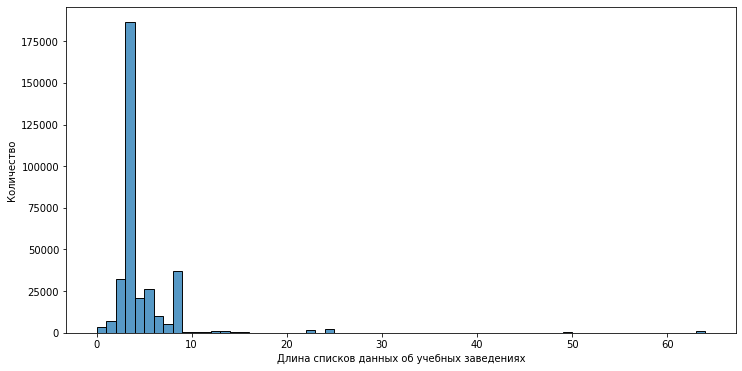

In [183]:
# Построим гистогамму распределения длин списков данных о расстоянии до учебных заведений:
plt.figure(figsize = (12,6))
sns.histplot(data=lst_dist, bins=np.arange(0, 65))
plt.ylabel('Количество')
plt.xlabel('Длина списков данных об учебных заведениях')

Видим, что диапазоны длин списков данных об учебных заведениях лежат в интервале от 0 до 65. Наиболее часто встречающаяся длина - 3 значения. При этом данные не упорядочены по расстоянию, либо рейтингу учебных заведений.

In [184]:
# проведем проверку равенства длинны списков с данными об учебных заведениях:
def checkList(data_t):
	lst = [len((ast.literal_eval(data_t))[0]['rating']),
           len((ast.literal_eval(data_t))[0]['data']['Distance']),
           len((ast.literal_eval(data_t))[0]['data']['Grades']),
           len((ast.literal_eval(data_t))[0]['rating'])]
	ele = lst[0]
	chk = True
	# сравниваем каждый элемент с первым:
	for item in lst:
		if ele != item:
			chk = False
			break
	if (chk == True):
		return 1
	else:
		return 0
# создадим столбец-индикатор равенства длин списков с данными об учебных заведениях:
data['temp_col'] = data['schools'].apply(checkList)

In [185]:
# определим колчество записей с разными длинами списков характеристик учебных заведений:
data['temp_col'].value_counts()

1    333349
0      5584
Name: temp_col, dtype: int64

Всего в датафрейм более 5 тыс. записей с несоответствиями длин списков характеристик об учебных заведениях, соответственно в данных записях нет возможности установить точное соответствие между учебным заведением и его характеристиками (рейтногом, расстоянием, оценками).

In [186]:
# выведем примеры записей с разной длиной списков характеристик учебных заведений:
data[data['temp_col']==0]['schools'].head(5)

3259     [{'rating': ['7', '6', '5', 'NR', '4', '6', 'N...
3556     [{'rating': ['NR', '6', '5', '8', 'NR', 'NR', ...
14873    [{'rating': ['7', '6', '5', '2', 'NR', '6', 'N...
14890    [{'rating': ['5', '4', '6', '1', '5', 'NR', 'N...
14897    [{'rating': ['7', '6', '5', '2', 'NR', '6', 'N...
Name: schools, dtype: object

Создадим отдельные столбцы с признаками данных об учебных заведениях из данных исходного столбца 'schools'

In [187]:
# функция получения имен признаков из списка словарей:
def dict_key2(col):
    dict_lst1 = ast.literal_eval(data[col][0])
    dict_lst2 = list(dict_lst1[0].keys())
    dict_lst3 = list(dict_lst1[0].values())
    var_lst = list(dict_lst3[1].keys())
    col_lst = []
    col_lst.append(dict_lst2[0])
    col_lst.append(dict_lst2[2])
    for i in range (0, len(dict_lst3[1])):
        col_lst.append(var_lst[i])
    return  col_lst

In [188]:
# получим список признаков учебных заведений:
dict_key2('schools') 

['rating', 'name', 'Distance', 'Grades']

In [189]:
# функция получения данных из исходного значения признака 'schools' (возвращает список значений):
def dict_val2(data2, key):
    dict_lst1 = (ast.literal_eval(data2))
    dict_lst2 = list(dict_lst1[0].keys())
    dict_lst3 = list(dict_lst1[0].values())
    for j in range (len(dict_lst3)):
        if dict_lst2[j] == key and key in ['name', 'rating']:
            return dict_lst3[j]
        elif dict_lst2[j] == 'data' and key in ['Distance', 'Grades']:
            return dict_lst1[0]['data'][key]

In [190]:
# создадим новые признаки из списка занчений признака schools:
col_lst = dict_key2(col)
for j in col_lst:
    data[j] = data[col].apply(dict_val2, key=j)

In [191]:
data.head(3)

,status,propertyType,baths,fireplace,city,schools,sqft,zipcode,beds,state,...,Heating,Cooling,Parking,lotsize,Price/sqft,temp_col,rating,name,Distance,Grades
0,Active,1 Story,4.0,0,san antonio,"[{'rating': ['10', '10', '8'], 'data': {'Dista...",3097,78260,5,TX,...,electric,central,Unknown,27878,152,1,"[10, 10, 8]","[Wilderness Oak Elementary School, Lopez Middl...","[2.9 mi, 1.8 mi, 4.4 mi]","[Preschool to 5, 6 to 8, 9 to 12]"
1,Active,1 Story,2.0,0,san antonio,"[{'rating': ['2', '2', '3'], 'data': {'Distanc...",1151,78222,2,TX,...,gas,central,Unknown,7575,149,1,"[2, 2, 3]","[Sinclair Elementary School, Legacy Middle Sch...","[0.6 mi, 1.5 mi, 5.5 mi]","[Preschool to 3, 6 to 8, 9 to 12]"
2,Active,1 Story,2.0,0,converse,"[{'rating': [], 'data': {'Distance': [], 'Grad...",1910,78109,3,TX,...,gas,central,Unknown,6392,136,1,[],[],[],[]


Приведем длины столбцов с характеристиками учебных заведений к единой длине для каждой записи (данны столбцов отличающиеся по длине трансформируем)

In [192]:
# При несоответтвии длин списков данных с характеристиками учебных заведений и длины списка данных с расстояниями 
# заполним соответствующие списки харектеристик списками занчений 'None' длины равной длине списка 'Distance':
for i in range(data.shape[0]):
    col_lst = dict_key2('schools') 
    for j in col_lst:
        if len(data.iloc[i, data.columns.get_loc(j)]) != len(data.iloc[i, data.columns.get_loc('Distance')]):
            new_lst = []
            for k in range(len(data.iloc[i, data.columns.get_loc('Distance')])):
                new_lst.append('None')
            data.iat[i, data.columns.get_loc(j)] = new_lst               

In [193]:
# снова проведем проверку равенства длинны списков с данными об учебных заведениях (во вновь созданных столбцах):
def checkList(row):
	lst = [len(row['Distance']),
           len(row['rating']),
           len(row['name']),
           len(row['Grades'])]
	ele = lst[0]
	chk = True
	# сравниваем каждый элемент с первым:
	for item in lst:
		if ele != item:
			chk = False
			break
	if (chk == True):
		return 1
	else:
		return 0
# создадим столбец-индикатор равенства длин списков с данными об учебных заведениях:
# data['temp_col'] = data['Distance', 'rating', 'name', 'Grades'].apply(checkList)
data['temp_col'] = data.apply(checkList, axis=1)

In [194]:
# определим колчество записей с разными длинами списков характеристик учебных заведений:
data['temp_col'].value_counts()

1    338933
Name: temp_col, dtype: int64

Записи с различными длинами списков характеристик учебных заведений отсутствуют.

In [195]:
# приведем данные о расстояниях до учебного заведения к цифровому виду: 
def dist_get(col):
    col_len = len(col)
    result_lst = []
    for i in range(col_len):
        num = re.search(r'\d*\.\d+|\d+', col[i])
        result_lst.append(float(num.group(0)))
    return result_lst    

In [196]:
# применим функцию dist_get к столбцу Distance (создав признак Distance2):
data['Distance2'] = data['Distance'].apply(dist_get)

In [197]:
# определим количество уникальных значений длин списков  расстояний до учебных заведений во вновь созданном признаке Distance2:
def len_d(col):
    col_len = len(col)
    return col_len  
data['len_d'] = data['Distance2'].apply(lambda x: len(x))
data['len_d'].value_counts()

3     186441
8      37209
2      32449
5      26160
4      20721
6      10058
1       7089
7       5083
0       3562
24      1973
22      1778
13      1049
12       859
63       764
10       747
11       728
15       515
9        505
14       433
65       340
49       263
61       124
16        40
21        26
17         9
26         5
19         3
Name: len_d, dtype: int64

In [198]:
data.head(3)

,status,propertyType,baths,fireplace,city,schools,sqft,zipcode,beds,state,...,Parking,lotsize,Price/sqft,temp_col,rating,name,Distance,Grades,Distance2,len_d
0,Active,1 Story,4.0,0,san antonio,"[{'rating': ['10', '10', '8'], 'data': {'Dista...",3097,78260,5,TX,...,Unknown,27878,152,1,"[10, 10, 8]","[Wilderness Oak Elementary School, Lopez Middl...","[2.9 mi, 1.8 mi, 4.4 mi]","[Preschool to 5, 6 to 8, 9 to 12]","[2.9, 1.8, 4.4]",3
1,Active,1 Story,2.0,0,san antonio,"[{'rating': ['2', '2', '3'], 'data': {'Distanc...",1151,78222,2,TX,...,Unknown,7575,149,1,"[2, 2, 3]","[Sinclair Elementary School, Legacy Middle Sch...","[0.6 mi, 1.5 mi, 5.5 mi]","[Preschool to 3, 6 to 8, 9 to 12]","[0.6, 1.5, 5.5]",3
2,Active,1 Story,2.0,0,converse,"[{'rating': [], 'data': {'Distance': [], 'Grad...",1910,78109,3,TX,...,Unknown,6392,136,1,[],[],[],[],[],0


Унифицируем длину списков характеристик учебных заведений. Ограничимся самой распространенной длинной - 3 значения. Для этого предварительно упорядочим характеристики по возрастанию значения дистанции до учебного заведения.

In [199]:
# переведем признак rating к числовому виду для дальнейшей сортировки:
def get_num2(col):
    result_lst = []
    for i in range(len(col)):
        if (col[i] in ['NR', 'None']) or ('None' in col[i]):
            result = -1
        elif col[i] == 'NA':
            result = -1
        else:
            num = re.search(r'\d+', col[i])
            result = int(num.group(0))
        result_lst.append(result)
    return result_lst

data['rating'] = data['rating'].apply(get_num2)

In [200]:
# Проведем сортировку списков значений характеристик учебных заведений по убыванию значений rating: 
for j in range(data.shape[0]):
    lst1=data.iloc[j, data.columns.get_loc('Distance2')]
    lst2=data.iloc[j, data.columns.get_loc('rating')]
    lst3=data.iloc[j, data.columns.get_loc('name')]
    lst4=data.iloc[j, data.columns.get_loc('Grades')]
    # Устанавливаем swapped в True, чтобы цикл запустился хотя бы один раз:
    swapped = True
    while swapped:
        swapped = False
        for i in range(0, len(lst2)-1):
            if lst2[i] < lst2[i + 1]:
                # Меняем элементы
                lst1[i], lst1[i + 1] = lst1[i + 1], lst1[i]
                lst2[i], lst2[i + 1] = lst2[i + 1], lst2[i]
                lst3[i], lst3[i + 1] = lst3[i + 1], lst3[i]
                lst4[i], lst4[i + 1] = lst4[i + 1], lst4[i]
                # Устанавливаем swapped в True для следующей итерации:
                swapped = True
            # сортировка по Distance(по возрастанию) если rating  равны:
            elif lst2[i + 1] == lst2[i]:
                if lst1[i] > lst1[i + 1]:
                    lst1[i], lst1[i + 1] = lst1[i + 1], lst1[i]
                    lst3[i], lst3[i + 1] = lst3[i + 1], lst3[i]
                    lst4[i], lst4[i + 1] = lst4[i + 1], lst4[i]
                    

In [201]:
# выравнивание длины до 3 элементов и замена отсутствующих значений на None:
col_lst = ['rating', 'Distance2', 'Grades', 'name']
def len_align(col):
    col_len = len(col)
    result_lst = col
    if col_len < 3:
        result_lst += ['None'] * (3 - col_len)
    elif col_len > 3: 
        result_lst = col[:3]  
    return result_lst 

for i in col_lst:
    data[i] = data[i].apply(len_align)

In [202]:
# разобьем значения новых признаков, являющихся списками из 3 значений на отдельные столбцы:
for i in col_lst:
    for j in range (3):
        data["{}-{}".format(i, j)]=data[i].apply(lambda x:x[j])    

In [203]:
data.head(3)

,status,propertyType,baths,fireplace,city,schools,sqft,zipcode,beds,state,...,rating-2,Distance2-0,Distance2-1,Distance2-2,Grades-0,Grades-1,Grades-2,name-0,name-1,name-2
0,Active,1 Story,4.0,0,san antonio,"[{'rating': ['10', '10', '8'], 'data': {'Dista...",3097,78260,5,TX,...,8,1.8,2.9,4.4,6 to 8,Preschool to 5,9 to 12,Lopez Middle School,Wilderness Oak Elementary School,Reagan High School
1,Active,1 Story,2.0,0,san antonio,"[{'rating': ['2', '2', '3'], 'data': {'Distanc...",1151,78222,2,TX,...,2,5.5,0.6,1.5,9 to 12,Preschool to 3,6 to 8,East Central High School,Sinclair Elementary School,Legacy Middle School
2,Active,1 Story,2.0,0,converse,"[{'rating': [], 'data': {'Distance': [], 'Grad...",1910,78109,3,TX,...,None,None,None,None,None,None,None,None,None,None


# 4.1 rating-[0, 2]

In [204]:
# переназначим пустые значения признаков rating-[0, 2]*:
cols = ['rating-0', 'rating-1', 'rating-2']
for item in cols:
    data[item] = data[item].replace({'None':-1})

In [205]:
# выведем перечень уникальных значений признака rating-0:
col = 'rating-0'
uniq_val_count(col)

 7     54647
 6     50864
 10    50027
 8     42082
 4     36435
 5     33413
 9     32859
 3     23802
 2      8395
-1      4343
 1      2066
Name: rating-0, dtype: int64
Число найденных уникальных значений = 11


# 4.2 name-[0, 2]

In [206]:
# выведем перечень уникальных значений признака name-0:
# pd.set_option("display.max_rows", None)
col = 'name-0'
uniq_val_order(col)

10th Street School                        10
A & M Cons High School                   255
A B Hill Elementary School                40
A Ball Charter School - Hearn Academy     10
A C Reynolds Middle                       11
                                        ... 
Zilwaukee K-8 School                       4
Zionsville Community High School           9
Zwink Elementary School                   11
d'Evelyn Junior/senior High School         4
e3 Civic High School                       5
Name: name-0, Length: 10554, dtype: int64
Число найденных уникальных значений = 10554


In [207]:
# в перечне уникальных значений присутствуют одинаковые значения, отличающиеся только регистром символов
# приведем все значения к нижнему регистру:
cols = ['name-0', 'name-1', 'name-2']
for item in cols:
    data[item] = data[item].str.lower()

In [208]:
# функция разбиения значений признаков name-[0,2] на категории по ключевым словам:
def school_name(name):
    new_name = ''
    if 'elementary' in name:
        new_name = 'elementary'       
    elif 'middle' in name:
        new_name = 'middle'
    elif 'high' in name:
        new_name = 'high'
    elif 'academy' in name:
        new_name = 'academy'    
    else:
        new_name = 'other'  
    return new_name  

# применим функцию school_name к признакам name-[0,2]:
for item in cols:
    data[item] = data[item].apply(school_name)

In [209]:
data.head(3)

,status,propertyType,baths,fireplace,city,schools,sqft,zipcode,beds,state,...,rating-2,Distance2-0,Distance2-1,Distance2-2,Grades-0,Grades-1,Grades-2,name-0,name-1,name-2
0,Active,1 Story,4.0,0,san antonio,"[{'rating': ['10', '10', '8'], 'data': {'Dista...",3097,78260,5,TX,...,8,1.8,2.9,4.4,6 to 8,Preschool to 5,9 to 12,middle,elementary,high
1,Active,1 Story,2.0,0,san antonio,"[{'rating': ['2', '2', '3'], 'data': {'Distanc...",1151,78222,2,TX,...,2,5.5,0.6,1.5,9 to 12,Preschool to 3,6 to 8,high,elementary,middle
2,Active,1 Story,2.0,0,converse,"[{'rating': [], 'data': {'Distance': [], 'Grad...",1910,78109,3,TX,...,-1,None,None,None,None,None,None,other,other,other


In [210]:
# кодируем информацию о названиях учебных заведений:
for item in cols:
    data[item] = data[item].astype('category')
    data[item] = data[item].cat.codes

# 4.3 Distance2-[0, 2]

В США при покупке дома самым решающим фактором является наличие хорошей школы рядом.   
Таким образом рейтинг близлежащих школ и расстояние до них оказывает непосредственное влияние на целевой признак (стоимость дома).  
https://dzen.ru/a/XSPRn6xBJACuRFrD


In [211]:
col = 'Distance2-0'
# выведем перечень уникальных значений признака Distance2-0:
uniq_val_count(col)

0.40     10572
0.30     10389
0.50     10124
0.60      9650
0.70      8916
         ...  
16.63        1
35.35        1
27.04        1
22.58        1
34.34        1
Name: Distance2-0, Length: 3237, dtype: int64
Число найденных уникальных значений = 3237


In [212]:
# переназначим пустые и нулевые значения признаков Distance2-[0, 2]*:
cols = ['Distance2-0', 'Distance2-1', 'Distance2-2']
for item in cols:
    data[item] = data[item].replace({'None':-1})
    data[item] = data[item].replace({0:-1})

Text(0.5, 0, 'Расстояние, миль')

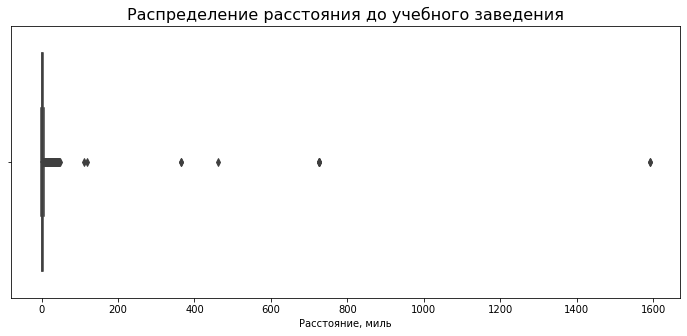

In [213]:
# Построим коробчатую диаграмму пртизнака Distance2-0: 
fig = plt.figure(figsize=(12, 5))
boxplot = sns.boxplot(data=data, x='Distance2-0')
boxplot.set_title('Распределение расстояния до учебного заведения', fontsize=16)
boxplot.set_xlabel('Расстояние, миль')

In [214]:
# определим количество записей с расстоянием более 40 миль до учебных заведений (на примере столбца Distance2-0):
data['Distance2-2'] = pd.to_numeric(data['Distance2-2'], errors='coerce', downcast='integer')
data[data['Distance2-2']>40]['schools'].shape[0]

11

Попробуем рассмотреть подробнее записи с аномальными значениями расстояний о учебных заведений.

In [215]:
# рассмотрим записи с расстоянием более 50 миль до учебных заведений (на примере столбца Distance2-0):
data[data['Distance2-2']>50]

,status,propertyType,baths,fireplace,city,schools,sqft,zipcode,beds,state,...,rating-2,Distance2-0,Distance2-1,Distance2-2,Grades-0,Grades-1,Grades-2,name-0,name-1,name-2
191307,For sale,Single Family,3.0,1,santa ana,"[{'rating': ['3/10', '1/10', '4/10'], 'data': ...",890,92703,2,TN,...,1,1591.06,1590.36,1591.00,9-12,K-5,5-8,2,1,4
203525,For sale,Single Family,3.0,1,spring,"[{'rating': ['9/10', '9/10', '6/10', '6/10'], ...",720,77380,2,TN,...,6,460.86,464.32,464.25,9-12,7-8,PK-4,2,2,1
242009,For sale,Single Family,3.0,1,santa ana,"[{'rating': ['3/10', '1/10', '4/10'], 'data': ...",890,92703,2,TN,...,1,1591.09,1590.38,1591.02,9-12,K-5,5-8,2,1,4
337039,Unknown,Unknown,2.0,0,cape coral,"[{'rating': ['3/10', '5/10', '5/10'], 'data': ...",1705,33993,3,FL,...,3,119.60,119.60,117.80,6-8,9-12,PK-5,3,2,1


В данном случае мы видим, что напиример для домовладения, расположенного в городе Spring неподадеку от Хьюстона (почтовый индекс = 77380) все указанные в записи 168432 учебные заведения находятся на расстоянии не менее 460 миль. Учебные заведения, расположенные на таком расстоянии явно не могут являються ближайшими к данному домовладению. При этом выборочная проверка расстояния до указанных учебных заведений на сайте https://www.google.com/maps  
(https://www.google.com/maps/place/Хейли+Элементари+Скул/@30.0633505,-95.4338831,11.5z/data=!4m6!3m5!1s0x8647341a944c2059:0x86581d54dc9a515b!8m2!3d30.1335815!4d-95.4653881!16s%2Fm%2F076knc0?entry=ttu)  
свидетельствует о том, что указанные расстояния являются ошибочными. Например расстояние до Hailey Elementary School составляет не более 7 км (около 4,4 мили), т.е. в 100 раз меньше. Таким образом данные расстояния либо являются ошибочно завышенными в 100 раз, либо рассчитаны ошибочно до населенных пунктов с таким же названием (на карте США 4 грода с названием Spring city).

Попробуем оценить верхнюю границу доверительного диапазона расстояний до учебного заведения.  
При средней скорости движения школьного автобуса (основной вид транспорта при доставке американских школьников в школу) в городской и пригородной черте не более 40 км/ч и времени доставки не более полутора часов, верхняя граница дистанции составит не более 60 км (37,3 мили).
Записей с расстояниями более 40 миль в столбцах Distance-[0, 2] в общей сложности 57 шт.  
Заменим данные расстояния на значение, соответствующее неопределенной величине дистанции (-1).

In [216]:
# заменим выбросы в значениях дистанции признаков Distance2-[0, 2]*:
cols = ['Distance2-0', 'Distance2-1', 'Distance2-2']
for item in cols:
    for i in range(data.shape[0]):
        if data.iloc[i, data.columns.get_loc(item)] > 40:
            data.iat[i, data.columns.get_loc(item)] = -1

Text(0.5, 0, 'Расстояние до учебнго заведения, миль')

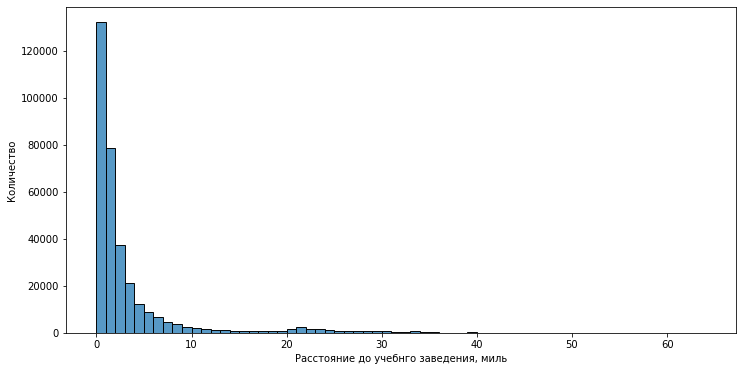

In [217]:
# Построим гистогамму распределения расстояний до учебных заведений на примере Distance2-0:
plt.figure(figsize = (12,6))
sns.histplot(data=data['Distance2-0'], bins=np.arange(0, 65))
plt.ylabel('Количество')
plt.xlabel('Расстояние до учебнго заведения, миль')

Text(0.5, 0, 'Расстояние, миль')

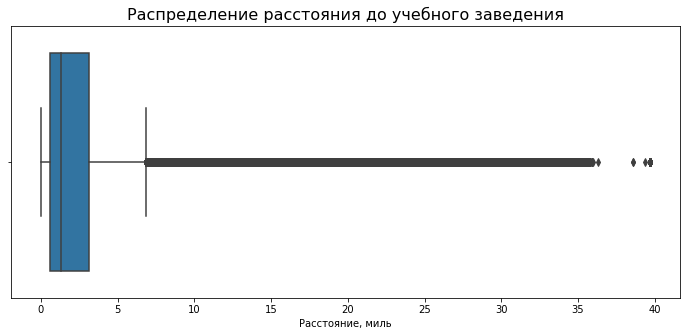

In [218]:
# Построим коробчатую диаграмму признака Distance2-0 после удаления выбросов: 
fig = plt.figure(figsize=(12, 5))
boxplot = sns.boxplot(data=data[data['Distance2-0']>0], x='Distance2-0')
boxplot.set_title('Распределение расстояния до учебного заведения', fontsize=16)
boxplot.set_xlabel('Расстояние, миль')
# boxplot.set_ylabel('Кол-во объектов недвижимости');

Согласно статичтическим данным на 2008 г. среднее расстояние до школы для учеников 6-12 лет составляет 3,6 мили.   
Для учеников старшего возраста среднее расстояние до школы увеличивается до 6 миль.  
https://nhts.ornl.gov/briefs/Travel%20To%20School.pdf  
Полученное распределение на коробчатой диаграмме вцелом соответствует статистическим данным.

# 4.4 Grades-[0, 2]

In [219]:
# выведем перечень уникальных значений признака Grades-0:
col = 'Grades-0'
uniq_val_count(col)

PK-5       60148
9-12       51806
6-8        33716
PK-8       26761
K-5        16286
           ...  
9-11           1
1 to 8         1
1 to 6         1
K to 11        1
2-8            1
Name: Grades-0, Length: 186, dtype: int64
Число найденных уникальных значений = 186


In [220]:
# переназначим пустые и равноценные значения признака:
cols = ['Grades-0', 'Grades-1', 'Grades-2']
to_remov = {'–':'-', ' to ':'-', 'Na':'Unknown', 'None':'Unknown', 'NA':'Unknown', 'N/A':'Unknown'}
for item in cols:
    data[item] = data[item].fillna('Unknown')
    for char in to_remov.keys():
    # вызов функции sub из модуля re
        data[item] = data[item].astype('str').apply(lambda x: re.sub(char, to_remov[char], x))


In [221]:
# кодируем информацию о классах учебных заведений:
for item in cols:
    data[item] = data[item].astype('category')
    data[item] = data[item].cat.codes
data.head(3)

,status,propertyType,baths,fireplace,city,schools,sqft,zipcode,beds,state,...,rating-2,Distance2-0,Distance2-1,Distance2-2,Grades-0,Grades-1,Grades-2,name-0,name-1,name-2
0,Active,1 Story,4.0,0,san antonio,"[{'rating': ['10', '10', '8'], 'data': {'Dista...",3097,78260,5,TX,...,8,1.8,2.9,4.4,35,96,65,3,1,2
1,Active,1 Story,2.0,0,san antonio,"[{'rating': ['2', '2', '3'], 'data': {'Distanc...",1151,78222,2,TX,...,2,5.5,0.6,1.5,50,94,50,2,1,3
2,Active,1 Story,2.0,0,converse,"[{'rating': [], 'data': {'Distance': [], 'Grad...",1910,78109,3,TX,...,-1,-1.0,-1.0,-1.0,92,101,112,4,4,4


In [222]:
# удалим исходный признаки schools, rating, name, Distance, Grades, Distance2, а также вспомогательные признаки temp_col, len_d:
data = data.drop(['schools', 'rating', 'name', 'Distance', 'Grades', 'Distance2','len_d', 'temp_col'], axis=1)

# 14. mls-id, MlsId

MLS - это онлайновая база данных общей всеобъемлющей домашней информации среди профессионалов в сфере недвижимости. Брокеры списков вводят данные о доме, который продается.  
MLS ID содержит все данные о доме, в том числе адрес, возраст, площадь, количество спален, количество ванн, улучшений и школьных округов. 
При этом данные, доступные для общественности, обычно ограничены и могут быть устаревшими или неточными.

Выборочная проверка представленных в датафрейм MLS ID на сайтах:  
https://www.mls.com  
https://www.trulia.com    
https://www.zillow.com  
результата не дала, поэтому изввлечь какие-либо дополнительные данные о домовладении из данных признаков возможности нет.

In [223]:
data.MlsId.value_counts()[:50]

NO MLS                        24
No MLS #                      16
 A, Houston, TX 77008         13
 12A, Orlando, FL 32833       11
 B, Houston, TX 77008          9
 1, South Boston, MA 02127     9
No                             9
 B, Houston, TX 77007          8
 11A, Orlando, FL 32833        8
 2, Washington, DC 20002       8
 1, Washington, DC 20002       7
 2, Washington, DC 20010       7
 2, Washington, DC 20009       6
 0, Doral, FL 33178            6
 1A, Orlando, FL 32833         6
 3A, Orlando, FL 32833         6
No MLS                         6
 A, Austin, TX 78721           6
 2, Boston, MA 02129           6
No mls                         6
 1, Washington, DC 20001       6
 A, Austin, TX 78704           6
 1, Washington, DC 20010       6
 2, Washington, DC 20001       6
14181176                       5
1412350                        5
14187092                       5
14237217                       5
1019437                        5
14168512                       5
14168541  

In [224]:
# удалим признаки mls-id, MlsId:
data = data.drop(['mls-id', 'MlsId'], axis=1)

# 17. target

In [225]:
col = 'target'
# выведем перечень уникальных значений признака:
uniq_val_count(col)

NaN           2358
$225,000      1424
$275,000      1304
$250,000      1267
$350,000      1237
              ... 
$349,700+        1
$233,340         1
$425,940+        1
$574,996+        1
$1,677,060       1
Name: target, Length: 40424, dtype: int64
Число найденных уникальных значений = 40424


In [226]:
# удалим строки, в которых отсутствуют значения целевого признака
data.dropna(subset=['target'], inplace=True)

In [227]:
# удалим символы '\$', ',', '\+', '/mo', ' ' из значений целевого признака:
symb_lst = ['\$', ',', '\+', '/mo', ' ']
for i in symb_lst:
    data[col] = data[col].astype('str').apply(repl_symb, w1=i, w2='')

In [228]:
uniq_val_count(col)

225000    1748
250000    1594
275000    1585
350000    1559
325000    1499
          ... 
283255       1
274550       1
406209       1
672955       1
173260       1
Name: target, Length: 31851, dtype: int64
Число найденных уникальных значений = 31851


In [229]:
# удалим значение '1215-1437' из значений целевого признака, заменив на среднее значение данного интервала цены:
data[col] = data[col].astype('str').apply(repl_symb, w1='1215-1437', w2='1326')

In [230]:
# Переводим в числовой формат
data[col] = data[col].apply(lambda x: int(x))

In [231]:
# удалим пропуски и единичные значения целевго признака:
# data.dropna(subset=[col])
data = data[data[col] != 1]
data = data.reset_index(drop=True)

Text(0.5, 0, 'Стоимость, долларов')

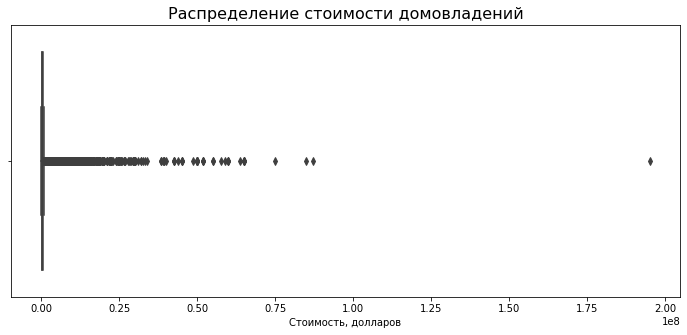

In [232]:
# Построим коробчатую диаграмму пртизнака target: 
fig = plt.figure(figsize=(12, 5))
boxplot = sns.boxplot(data=data, x='target')
boxplot.set_title('Распределение стоимости домовладений', fontsize=16)
boxplot.set_xlabel('Стоимость, долларов')

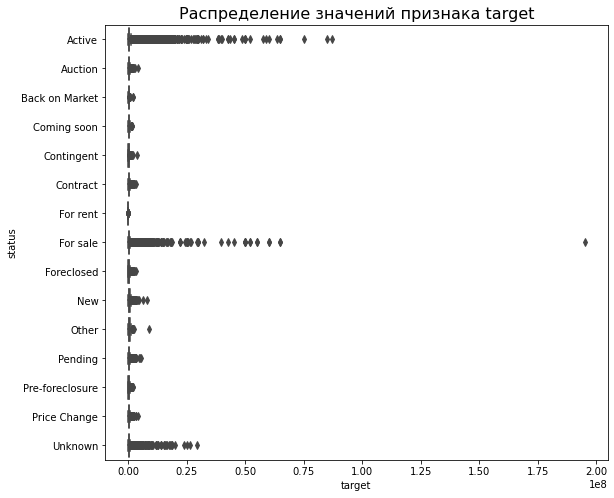

In [233]:
# потроим коробчатую диаграмму распределения стоимости домовладений в разрезе их статуса:
box_plot(col, bn='status')

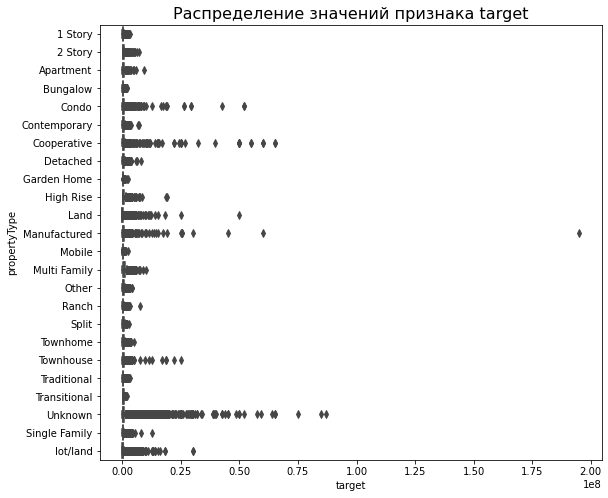

In [234]:
# потроим коробчатую диаграмму распределения стоимости домовладений в разрезе типа собственности:
box_plot(col, bn='propertyType')

Диаграммы распределения свидетельствуют о наличии выбросов в целевом признаке со стоимостью в сотни миллионов долларов за домовладение.

In [235]:
# логарифмируем целевой признак для его нормализации и повышения качества работы модели:
data[col] = np.log(data[col])

In [236]:
# удалим выбросы в разрезе уникальных значений контрольного признака status:
data = m_del(col, crit='status')

15
New Shape:  (295871, 30)


In [237]:
# дополнительно удалим выбросы в разрезе уникальных значений контрольного признака propertyType:
data = m_del(col, crit='propertyType')

24
New Shape:  (258844, 30)


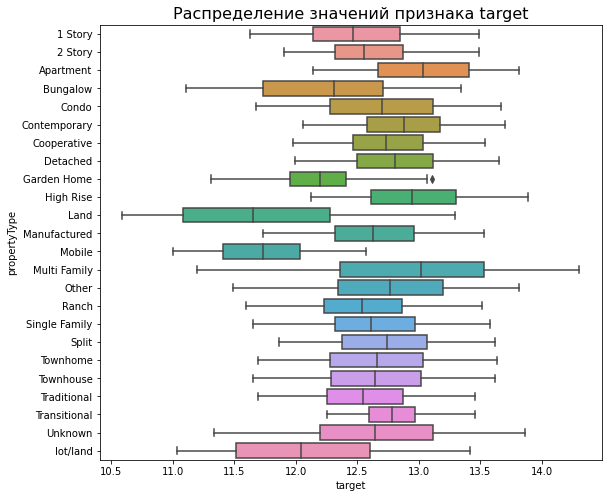

In [238]:
# потроим коробчатую диаграмму распределения стоимости домовладений в разрезе типа собственности:
box_plot(col, bn='propertyType')

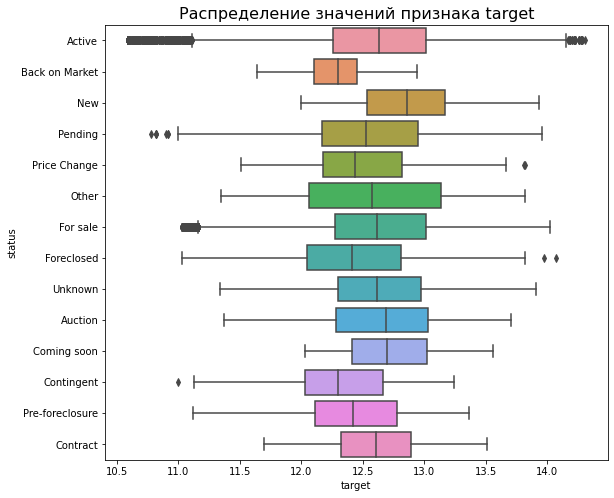

In [239]:
# потроим коробчатую диаграмму распределения стоимости домовладений в разрезе статуса собственности:
box_plot(col, bn='status')

Видим, что тип собственности и статус в значительной мере влияет на распределение значений целевого признака. Таким образом проведенное выше удаление выбросов в разрезе признаков ('propertyType', 'status') является оправданным.

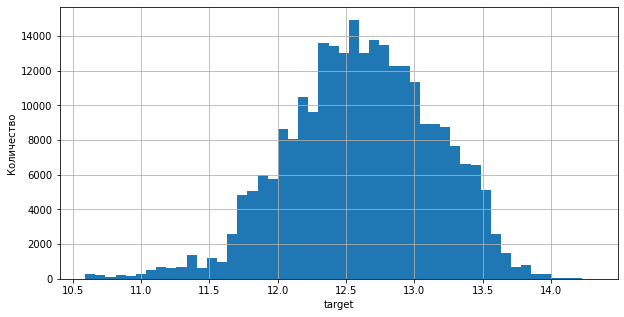

In [240]:
# построеним гистогамму распределения значений признака после преобразований:
sign_hist(col, 50)

In [241]:
data.shape[0]

258844

## ПРОЕКТИРОВАНИЕ ПРИЗНАКОВ

Создадим новые признаки со средними значениями дистанции до учебного заведения и средними значениями рейтинга учебного заведения

In [242]:
# создание новых признаков из средних значений:
cols_r = ['rating-0', 'rating-1', 'rating-2']
cols_d = ['Distance2-0', 'Distance2-1', 'Distance2-2']

data['avg_rating'] = -1
data['avg_Distance'] = -1

for i in range(data.shape[0]):
    s=0
    k=0
    for j in cols_r:
        if data.iloc[i, data.columns.get_loc(j)] > 0:
            s=s+data.iloc[i, data.columns.get_loc(j)] 
            k=k+1
        elif data.iloc[i, data.columns.get_loc(j)] == -1:
            s=s
            k=k
    if k>0:
        data.iat[i, data.columns.get_loc('avg_rating')] = round(s/k, 2)  
    else: 
        data.iat[i, data.columns.get_loc('avg_rating')] = -1   
    
for i in range(data.shape[0]):
    s=0
    k=0
    for j in cols_d:
        if data.iloc[i, data.columns.get_loc(j)] > 0:
            s=s+data.iloc[i, data.columns.get_loc(j)] 
            k=k+1
        elif data.iloc[i, data.columns.get_loc(j)] == -1:
            s=s
            k=k
    if k>0:
        data.iat[i, data.columns.get_loc('avg_Distance')] = round(s/k, 2)  
    else: 
        data.iat[i, data.columns.get_loc('avg_Distance')] = -1 

In [243]:
# Переводим в числовой формат:
data['avg_rating'] = data['avg_rating'].apply(lambda x: float(x))
data['avg_Distance'] = data['avg_Distance'].apply(lambda x: float(x))

In [244]:
# проверим корректность расчета средних значений дистанции и рейтинга учебных заведений:
data[['rating-0', 'rating-1', 'rating-2', 'avg_rating', 'Distance2-0', 'Distance2-1', 'Distance2-2', 'avg_Distance']].head(10)

,rating-0,rating-1,rating-2,avg_rating,Distance2-0,Distance2-1,Distance2-2,avg_Distance
0,10,10,8,9.33,1.8,2.9,4.4,3.03
1,3,2,2,2.33,5.5,0.6,1.5,2.53
2,-1,-1,-1,-1.00,-1.0,-1.0,-1.0,-1.00
3,8,8,-1,8.00,7.9,22.2,1.1,10.40
4,5,4,3,4.00,0.4,0.8,3.1,1.43
5,3,1,1,1.67,0.5,0.5,1.4,0.80
6,4,4,2,3.33,0.5,1.6,3.0,1.70
7,10,9,7,8.67,10.2,0.7,1.4,4.10
8,7,6,6,6.33,1.4,0.2,0.7,0.77
9,8,7,6,7.00,0.7,0.4,0.5,0.53


Создадим новые признаки учитывающие данные об уровне дохода на душу населения и об уровне смертности от насильственных преступлений в разрезе штата

https://worldpopulationreview.com/state-rankings/murder-rate-by-state  
https://ru.wikipedia.org/wiki/Список_штатов_США_по_уровню_убийств

In [245]:
# исключим записи с некорректными двухбуквенными обозначениями штатов:
data = data[(data['state'] != 'OT') &  (data['state'] != 'OS') & (data['state'] != 'BA')]

In [246]:
# создадим словарь соответствия обозначений штатов и уровня смертности от насильственных преступлений:
dict_murder = {'FL':7.4, 'TX':8.2, 'CA':6.4, 'NC':9.7, 'NY':4.8, 'TN':12.2, 'WA':4.5, 'OH':9.3, 'NV':8.5, 'IL':12.3, 'GA':11.4, 
               'MI':8.7, 'CO':6.3, 'PA':9.2, 'DC':30.0, 'IN':9.6, 'AZ':8.1, 'OR':4.9, 'MA':2.3, 'UT':2.7, 'MD':12.2, 'MO':12.4, 
               'VA':7.2, 'VT':2.2, 'WI':6.4, 'IA':3.2, 'NJ':4.8, 'KY':9.6, 'ME':1.7, 'OK':8.9, 'SC':13.4, 'MS':23.7, 'DE':11.3, 
               'MT':4.4, 'AL':15.9, 'IN':9.6}

In [247]:
# заполним вновь созданный столбец 'murder' данными об уровне смертности от насильственных преступлений по штатам:
data['murder'] = data['state'].map(dict_murder)
data['murder'] = data['murder'].apply(lambda x: float(x))


In [248]:
# создадим словарь соответствия обозначений штатов и уровня дохода на душу населения:
dict_income = {'FL':63.062, 'TX':66.963, 'CA':84.907, 'NC':61.972, 'NY':74.314, 'TN':59.695, 'WA':84.247, 'OH':62.262, 'NV':66.274, 
               'IL':72.205, 'GA':66.559, 'MI':63.498, 'CO':82.254, 'PA':68.957, 'DC':92.266, 'IN':62.743, 'AZ':69.056, 'OR':71.562, 
               'MA':89.645, 'UT':79.449, 'MD':90.203, 'MO':61.847, 'VA':80.963, 'VT':72.431, 'WI':67.125, 'IA':65.600, 'NJ':89.296, 
               'KY':55.573, 'ME':64.767, 'OK':55.826, 'SC':59.318, 'MS':48.716, 'DE':71.091, 'MT':63.249, 'AL':53.913, 'IN':62.743}

In [249]:
# заполним вновь созданный столбец 'income' данными об уровне дохода на душу населения по штатам:
data['income'] = data['state'].map(dict_income)
data['income'] = data['income'].apply(lambda x: float(x))

In [250]:
data.shape[0]

258843

### ЗАВЕРШИМ КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

In [251]:
# кодирование категориальных признаков с помощью метода cat.codes:
cols_cat = ['PrivatePool', 'city', 'zipcode', 'Heating', 'Cooling', 'Parking', 'state']
for item in cols_cat:
    data[item] = data[item].astype('category')
    data[item] = data[item].cat.codes

In [252]:
# # кодирование категориальных признаков с помощью метода бинарного кодирования:
cols_cat = ['status', 'propertyType']
for item in cols_cat:
    binary_cod(item)
data = data.drop(['status', 'propertyType'], axis=1)  

In [253]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258843 entries, 0 to 258843
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           258843 non-null  float64
 1   fireplace       258843 non-null  int64  
 2   city            258843 non-null  int16  
 3   sqft            258843 non-null  int64  
 4   zipcode         258843 non-null  int16  
 5   beds            258843 non-null  int64  
 6   state           258843 non-null  int8   
 7   PrivatePool     258843 non-null  int8   
 8   target          258843 non-null  float64
 9   Year built      258843 non-null  int64  
 10  Remodeled year  258843 non-null  int64  
 11  Heating         258843 non-null  int8   
 12  Cooling         258843 non-null  int8   
 13  Parking         258843 non-null  int8   
 14  lotsize         258843 non-null  int64  
 15  Price/sqft      258843 non-null  int64  
 16  rating-0        258843 non-null  int64  
 17  rating-1  

## АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ ПРИЗНАКОВ

In [254]:
# определим функцию построения корреляционной диаграммы признаков:
def show_corr_heatmap(columns_list, title, method):
    fig_, ax_ = plt.subplots(figsize=(45, 40))
    corr = data[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                annot_kws={"fontsize":18},
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=36)
    plt.show()
    

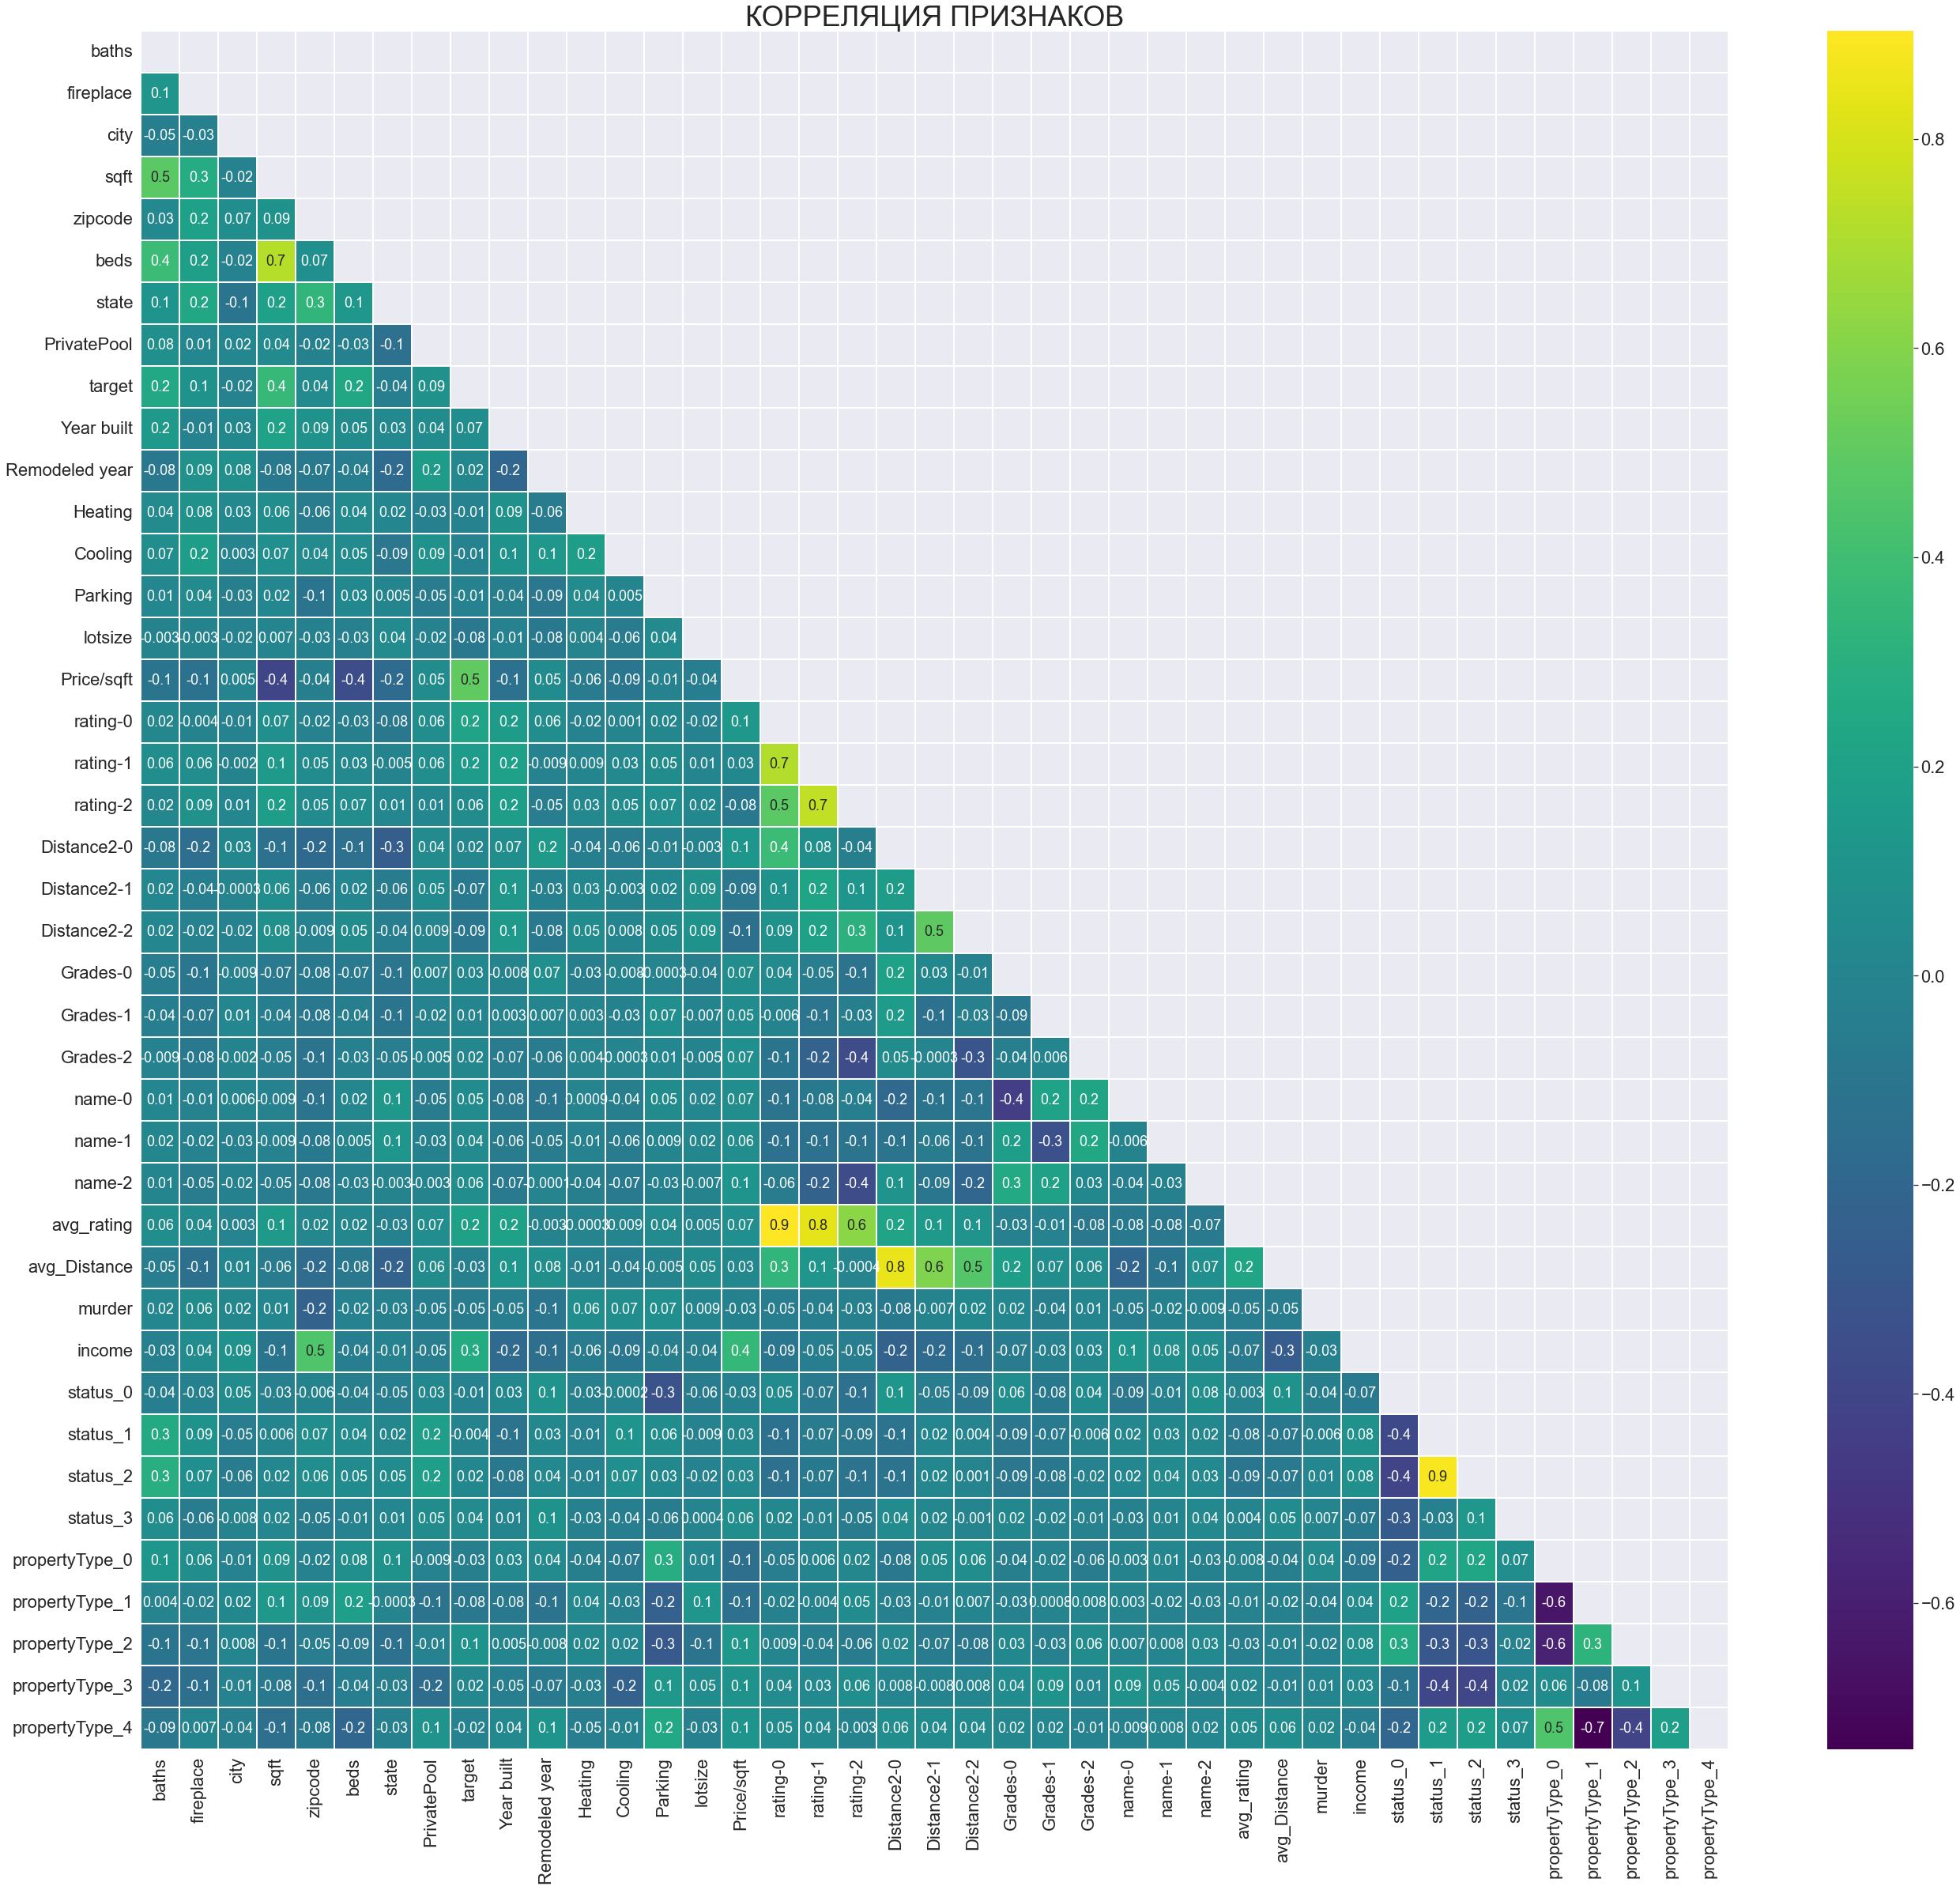

In [255]:
# строим диаграмму для всех признаков (включая целевой):
sns.set(font_scale=2) 
show_corr_heatmap(data.columns, 'КОРРЕЛЯЦИЯ ПРИЗНАКОВ', method='pearson');
sns.set(font_scale=1) 

Видим, что ожидаемо наблюдается корреляция с коэффициентом 0,6-0,9 между средними значениями рейтинга и дистанции и частными значениями этих величин для ближайших учебных заведений. Присутствует кореляция с коэффициентом 0.7 между количеством спален и площадью недвижимости.
Отметим также значимую корреляция между Price/sqft и целевым признаком, что является подтверждением того, что Price/sqft является утечкой.

In [256]:
# удалим признак Price/sqft
data = data.drop('Price/sqft', axis = 1)

In [257]:
# удалим признаки с частными значениями рейтинга и дистанции:
cat_del = ['rating-0','rating-1','rating-2']
num_del = ['Distance2-0','Distance2-1','Distance2-2']
for item in (cat_del):
    data.drop(item, axis = 1, inplace = True)
    
for item in (num_del):   
    data.drop(item, axis = 1, inplace = True)

In [258]:
# удалим записи, содержащие отрицательные значения (-1) 
# т.е. записи с отсутствующими полностью данными о расстояниях и рейтингах учебных заведений:
mylist2 = list(data.columns)
for elem in mylist2:
    data = data[data[elem] != -1]
data.shape[0]

255925

## ОЦЕНКА ЗНАЧИМОСТИ ПРИЗНАКОВ

Для оценки значимости признаков будем использовать функцию f_classif из библиотеки sklearn (в основе метода оценки значимости переменных лежит анализ ANOVA)

In [259]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# копируем исходный датасет
data_mm = mm_scaler.fit_transform(data)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
col_names = list(data.columns)
data_mm = pd.DataFrame(data_mm, columns=col_names)

In [260]:
# Проверим датасет на наличие пропусков в данных
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(
    ascending=False)
cols_with_null

Series([], dtype: float64)

In [261]:
# выделим целевой признак для анализа значимости для:
X = data_mm.drop(['target'], axis = 1)  
y = data_mm['target'] 

<AxesSubplot:>

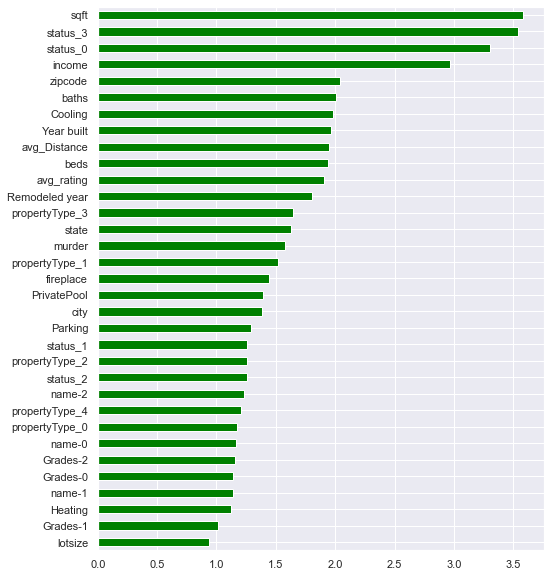

In [262]:
# визуализируем результат анализа значимости признаков:
imp_num = pd.Series(f_classif(X, y)[0], X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(8, 10))
imp_num.plot(kind = 'barh', color='green')

Оставшиеся признаки показывают наличие отличной от нуля значимости и будут использованы для построения модели.

## ПОСТРОЕНИЕ МОДЕЛИ, ВАЛИДАЦИЯ РЕЗУЛЬТАТОВ И ОЦЕНКА КАЧЕСТВА МОДЕЛИ

In [263]:
data.shape

(255925, 34)

С учетом большого значения записей используем hold-out метод валидации

In [264]:
# разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х — данные с информациея о домовладениях, у — целевая переменная (цена)  
data_copy = data.copy()
y = data_copy['target']
X = data_copy.drop(columns='target')

In [265]:
# разбиваем исходную выборку на тренировочную и валидационную в соотношении 70/30
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
# разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)
# Выводим результирующие размеры таблиц
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)
print('Valid:', X_valid.shape, y_valid.shape)

Train: (179147, 33) (179147,)
Test: (38389, 33) (38389,)
Valid: (38389, 33) (38389,)


In [266]:
# сохраним валидационную часть датафрейм для последующего использования при запросе в серверном приложении:
# X_valid.to_csv(r'data\\x_valid.csv', index=False)
# y_valid.to_csv(r'data\\y_valid.csv', index=False)
data_valid = pd.concat([X_valid, y_valid], axis=1)
data_valid.to_csv(r'Docker\src\\libs\data_valid.csv', index=False)

In [267]:
# Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
# Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
# Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

В дальнейшем подбор параметров используемых моделей осуществлялся в основном методом ручного подбора т.к. автоматический подбор с учетом значительной величины датафрейм потребовал больших затрат времени (до десятков часов).

#### ЛИНЕЙНАЯ РЕГРЕССИЯ

In [268]:
# Создаём объект класса LinearRegression
lr_model = linear_model.LinearRegression()
# Обучаем модель по МНК
lr_model.fit(X_train_scaled, y_train) 
# Делаем предсказание для тренировочной выборки
y_train_predict = lr_model.predict(X_train_scaled)
# Делаем предсказание для тестовой выборки
y_test_predict = lr_model.predict(X_test_scaled)
print("Train R^2: {:.3f}".format(metrics.r2_score(np.exp(y_train), np.exp(y_train_predict))))
print("Test R^2: {:.3f}".format(metrics.r2_score(np.exp(y_test), np.exp(y_test_predict))))
print('MAPE:', metrics.mean_absolute_percentage_error(np.exp(y_test), np.exp(y_test_predict)))
print('rmse:', rmse(np.exp(y_test), np.exp(y_test_predict)))

Train R^2: 0.308
Test R^2: 0.304
MAPE: 0.3592061078999254
rmse: 152012.44907345923


#### ЛИНЕЙНАЯ РЕГРЕССИЯ С L1-РЕГУЛЯРИЗАЦИЕЙ

In [269]:
# Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
# Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
# Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (179147, 594)
Test shape: (38389, 594)


In [270]:
# Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.5)
# Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
# Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
# Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
# Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(np.exp(y_train), np.exp(y_train_predict_poly))))
print("Test R^2: {:.3f}".format(metrics.r2_score(np.exp(y_test), np.exp(y_test_predict_poly))))
print('MAPE:', metrics.mean_absolute_percentage_error(np.exp(y_test), np.exp(y_test_predict_poly)))
print('rmse:', rmse(np.exp(y_test), np.exp(y_test_predict_poly)))

Train R^2: -0.058
Test R^2: -0.060
MAPE: 0.4842882283768401
rmse: 187622.05286226052


#### ЛИНЕЙНАЯ РЕГРЕССИЯ С L2-РЕГУЛЯРИЗАЦИЕЙ

In [271]:
# Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=0.1)
# Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
# Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
# Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
# Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(np.exp(y_train), np.exp(y_train_predict_poly))))
print("Test R^2: {:.3f}".format(metrics.r2_score(np.exp(y_test), np.exp(y_test_predict_poly))))
print('MAPE:', metrics.mean_absolute_percentage_error(np.exp(y_test), np.exp(y_test_predict_poly)))
print('rmse:', rmse(np.exp(y_test), np.exp(y_test_predict_poly)))


Train R^2: 0.478
Test R^2: 0.475
MAPE: 0.2949686485111336
rmse: 132054.14419621043


## АНСАМБЛЕВЫЕ МЕТОДЫ

### БЭГГИНГ

#### РЕШАЮЩЕЕ ДЕРЕВО

In [272]:
# # Подбор параметров для модели:
# param_grid = {'max_depth':  list(np.linspace(1, 20, 10, dtype=int))} 
# grid_search = GridSearchCV(
#     estimator=DecisionTreeRegressor(random_state=42), 
#     param_grid=param_grid
# )  
# grid_search.fit(X_train, y_train) 
# #print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
# y_test_pred = grid_search.predict(X_test)

# print('MAPE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)))
# print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

# # MAPE на тестовом наборе: 14.06
# # Наилучшие значения гиперпараметров: {'max_depth': 15}

In [273]:
# Создаём объект класса решаюшее дерево:
regr1 = DecisionTreeRegressor(max_depth=15, random_state=42)
# Обучаем модель:
regr1.fit(X_train_scaled, y_train)
y_pred1 = regr1.predict(X_test_scaled)
# Качество предсказания для решающего дерева:
print("Test R^2: {:.3f}".format(metrics.r2_score(np.exp(y_test), np.exp(y_pred1))))
print('MAPE:', metrics.mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred1)))
print('rmse:', rmse(np.exp(y_test), np.exp(y_pred1)))

Test R^2: 0.597
MAPE: 0.2471402990285701
rmse: 115645.45867969112


#### СЛУЧАЙНЫЙ ЛЕС

In [274]:
# # Подбор параметров для модели:
# param_grid = {'max_depth': list(np.linspace(1, 100, 10, dtype=int))},
#             #    'n_estimators':  list(range(10, 100, 10)) } 
# grid_search = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=42), 
#     param_grid=param_grid
# )  
# grid_search.fit(X_train, y_train) 
# #print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
# y_test_pred = grid_search.predict(X_test)

# print('MAPE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)))
# print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

# # MAPE на тестовом наборе: 0.02
# # Наилучшие значения гиперпараметров: {'max_depth': 45}


In [275]:
# Создаём объект класса случайный лес:
regr2 = RandomForestRegressor(max_depth=45, n_estimators=100, random_state=42)
# Обучаем модель:
regr2.fit(X_train, y_train)
y_pred2 = regr2.predict(X_test)
# Качество предсказания для случайного леса: 
print("Test R^2: {:.3f}".format(metrics.r2_score(np.exp(y_test), np.exp(y_pred2))))
print('MAPE:', metrics.mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred2)))
print('rmse:', rmse(np.exp(y_test), np.exp(y_pred2)))


Test R^2: 0.752
MAPE: 0.17684251310426047
rmse: 90825.11552970504


### СТЕКИНГ

In [276]:
# Создаем список кортежей вида: (наименование модели, модель):
estimators = [
    ('lr', RidgeCV()),
    ('dt',  DecisionTreeRegressor(random_state=42))
]
# Создаем объект класса стекинг:
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=15,
                                          max_depth=5,
                                          random_state=42)
)
# Обучаем модель:
reg.fit(X_train, y_train)
y_pred_stack = reg.predict(X_test)

print("Test R^2: {:.3f}".format(metrics.r2_score(np.exp(y_test), np.exp(y_pred_stack))))
print('MAPE:', metrics.mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred_stack)))
print('rmse:', rmse(np.exp(y_test), np.exp(y_pred_stack)))

Test R^2: 0.603
MAPE: 0.24480216516602857
rmse: 114908.12575556998


### БУСТИНГ

In [277]:
# # Подбор параметров для модели:
# param_grid = {'n_estimators':  list(range(10, 200, 20)) } 
# grid_search = GridSearchCV(
#     estimator=AdaBoostRegressor(random_state=42), 
#     param_grid=param_grid
# )  
# grid_search.fit(X_train, y_train) 
# #print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
# y_test_pred = grid_search.predict(X_test)

# print('MAPE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)))
# print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

# #

In [278]:
# Создаём объект класса
dt = DecisionTreeRegressor(
    max_depth=3, 
    random_state=42
)
ada = AdaBoostRegressor(
    base_estimator=dt,
    random_state=42, 
    n_estimators=10
)
# Обучаем модель
ada.fit(X_train, y_train)
ada_pred  = ada.predict(X_test)

print("Test R^2: {:.3f}".format(metrics.r2_score(np.exp(y_test), np.exp(ada_pred))))
print('MAPE:', metrics.mean_absolute_percentage_error(np.exp(y_test), np.exp(ada_pred)))
print('rmse:', rmse(np.exp(y_test), np.exp(ada_pred)))


c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



Test R^2: 0.229
MAPE: 0.37361049933004403
rmse: 160014.52949430665


### ГРАДИЕНТНЫЙ БУСТИНГ

In [279]:
# # Подбор параметров для модели:
# param_grid = {'max_depth': list(np.linspace(1, 10, 10, dtype=int)),
#                'n_estimators':  list(range(10, 100, 10)) } 
# grid_search = GridSearchCV(
#     estimator=GradientBoostingRegressor(random_state=42 ), 
#     param_grid=param_grid
# )  
# grid_search.fit(X_train, y_train) 
# #print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
# y_test_pred = grid_search.predict(X_test)

# print('MAPE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)))
# print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

# #

In [280]:
# gb = GradientBoostingRegressor(
# 	max_depth=25, # максимальная глубина дерева
# n_estimators=100, # количество деревьев
# random_state=42 # генератор случайных чисел
# )
# gb.fit(X_train, y_train) 
# gb_pred  = gb.predict(X_test)

# print("Test R^2: {:.3f}".format(metrics.r2_score(np.exp(y_test), np.exp(gb_pred))))
# print('MAPE:', metrics.mean_absolute_percentage_error(np.exp(y_test), np.exp(gb_pred)))
# print('rmse:', rmse(np.exp(y_test), np.exp(gb_pred)))


### ВЫВОДЫ (ВЫБОР МОДЕЛИ)

Наилучшее качество предсказания получено с использованием модели "Случайный лес". Именно эту модель используем для сохранения в файл (серилизации) и последующего использования.

In [281]:
data.shape[0]

255925

## PICKLE

In [282]:
# записываем результат в файл
with open('Docker\src\libs\model.pkl', 'wb') as output:
    pickle.dump(regr2, output)

In [283]:
regr2

RandomForestRegressor(max_depth=45, random_state=42)

In [284]:
# десериализуем модель из файла
with open('Docker\src\libs\model.pkl', 'rb') as pkl_file:
    model = pickle.load(pkl_file)
    df = pd.read_csv("Docker/src/libs/data_valid.csv")

# Формируем предсказание
    df_x = df.drop('target', axis=1)
    y_pred = model.predict(df_x)   
    y_valid = df['target']

print("Test R^2: {:.3f}".format(metrics.r2_score(np.exp(y_valid), np.exp(y_pred))))
print('MAPE:', metrics.mean_absolute_percentage_error(np.exp(y_valid), np.exp(y_pred)))
print('rmse:', rmse(np.exp(y_valid), np.exp(y_pred)))



Test R^2: 0.751
MAPE: 0.17696345923826776
rmse: 90983.45282353435


### РЕАЛИЗАЦИЯ В ПРОДАКШН

Далее с использованием docker и flask реализован интерфейс для получения предсказания и вывода результирующих метрик.

Структура контейнера:

In [285]:
# rea_container
#       ├─src
#           └─libs
#                └─model.pkl
#                └─data_valid.csv
#           └─server.py
#           └─client.py
#       └─Dockerfile
#       └─requirements.txt

где:
- model.pkl - сохраненный файл модели;  
- data_valid.csv - предварительно сохораненная часть исходного датасета для валидации модели;  
- server.py - файл клиентского приложения;  
- Dockerfile - специальный файл, в котором содержатся инструкции по сборке контейнера;  
- requirements.txt - файл с указанием необходимых библиотек и их версий.  

При запуске клиентского приложения происходит запрос к серверной части (отправка валидационной части датасет data_valid.csv). Серверная часть  поучает предсказание с использованием сохраненного файла модели (model.pkl), возвращая предсказание в виде серверного ответа клиернтскому приложению, где происходит вывод результирующих метрик. 


_________________________________________________